In [ ]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu, wilcoxon, ttest_rel, ttest_ind
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ColorConverter


PROJECT_PATH = os.getcwd()
sys.path.append(PROJECT_PATH)

In [230]:
# ANT_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_remapping\ANT"
# NON_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_remapping\NON"
# B6_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_remapping\B6"
# dfs = []
# for path in [ANT_path, NON_path, B6_path]:
#     for animal_dir in os.listdir(path):
#         for csv_file in os.listdir(path + r'\\' + animal_dir):
#             if csv_file.endswith('.xlsx'):
#                 file_df = pd.read_excel(path + r'\\' + animal_dir + r'\\' + csv_file)
#                 # add column for genotype
#                 if path == ANT_path:
#                     file_df['group'] = 'ANT'
#                 elif path == NON_path:
#                     file_df['group'] = 'NON'
#                 elif path == B6_path:
#                     file_df['group'] = 'B6'
#                 dfs.append(file_df)

# df = pd.concat(dfs, ignore_index=True)

# df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_full_merged_scores.xlsx')
df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_keep_swapped.xlsx')
print(df.columns, len(df))

Index(['Unnamed: 0', 'signature', 'depth', 'name', 'date', 'tetrode',
       'unit_id', 'session_id', 'obj_pos', 'object_location', 'score',
       'field_id', 'field_count', 'obj_wass_0', 'obj_wass_90', 'obj_wass_180',
       'obj_wass_270', 'obj_wass_NO', 'obj_q_0', 'obj_q_90', 'obj_q_180',
       'obj_q_270', 'obj_q_NO', 'obj_vec_0', 'obj_vec_90', 'obj_vec_180',
       'obj_vec_270', 'obj_vec_NO', 'bin_area', 'total_rate',
       'field_peak_rate', 'spike_count', 'field_coverage', 'field_area',
       'field_rate', 'cumulative_coverage', 'cumulative_area',
       'cumulative_rate', 'arena_size', 'cylinder', 'ratemap_dims', 'spacing',
       'hexagonal', 'sample_size', 'downsample_factor', 'Session', 'Tetrode',
       'Cell ID', 'spike_width', 'spike_count.1', 'firing_rate',
       'Avg. Spikes/Burst', 'bursting', 'iso_dist', 'L_ratio', 'ISI_min',
       'ISI_max', 'ISI_mean', 'ISI_median', 'ISI_cv', 'ISI_std', 'sparsity',
       'selectivity', 'information', 'coherence', 'speed_scor

In [231]:
len(df)

74969

In [232]:
""" QUALITY CHECK DATA """ 
nan_idx = np.where(df['obj_q_0'].isna())[0]
not_nan_idx = np.where(~df['obj_q_0'].isna())[0]
nan_dates = (df['date'][nan_idx].unique())
nan_names = (df['name'][nan_idx].unique())

print('Number of NaN rows: ' + str(len(nan_idx)))
print('Animals with NaN rows: ' + str(nan_names))
print('Dates with NaN rows: ' + str(nan_dates))

# remove rows with NaN values
print('Removing nan rows')
df = df.iloc[not_nan_idx]

Number of NaN rows: 10289
Animals with NaN rows: [nan]
Dates with NaN rows: [nan]
Removing nan rows


In [33]:
""" OBJECT CELL DETECTION """

"""
Definition:

Cell with a field that is at the object location 

Criteria:
    - Quantile < threshold
    - Nmb of sessions detected
    - Consecutive vs non consecutive
    - Score to use (field or centroid)
    - Main field or all fields
"""
consecutive_sessions_threshold = 2
quantile_threshold = 0.2
consecutive = False
score = 'field'
main_field_only = False

In [34]:
# iterate through each row in df and add a column for 'group' based on the 'signature' split at the firsst '_'
df['signature'] = df['signature'].astype(str)
df['group'] = df['signature'].apply(lambda x: str(x.split('_')[0]))
# if the word 'ANT' is in the signature, then the group is 'ANT', if its 'B6' then the group is 'B6' if its 'NON' then the group is 'NON'
df['group'] = df['group'].apply(lambda x: 'B6' if 'B6' in x else x)
df['group'] = df['group'].apply(lambda x: 'NON' if 'NON' in x else x)
df['group'] = df['group'].apply(lambda x: 'ANT' if 'ANT' in x else x)

In [35]:
""" FILTERING """

""" REMOVE FIELD WITH LOW COVERAGE % """
# remove rows with field_coverage < 0.1
# df = df[df['field_coverage'] >= 0.1]

""" ONLY KEEPING MAIN FIELD """
# remove rows where field_id is not 1 and score is not 'whole' or 'spike_density'
# df = df[(df['field_id'] == 1) | (df['score'] == 'whole') | (df['score'] == 'spike_density')]

""" CHOOSING ANGLE FOR EACH ROW """
# for each row, choose lowest quantile from ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']
df['obj_q'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].min(axis=1)
df['obj_a'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].idxmin(axis=1)
# convert obj_a to degrees
df['obj_a'] = df['obj_a'].apply(lambda x: int(x.split('_')[2]))
# use obj_wass with angle of min quantile
df['obj_w'] = df.apply(lambda x: x['obj_wass_' + str(x['obj_a'])], axis=1)

""" ASSESSING SIG FOR EACH ROW AT EACH ANGLE """
obj_s_rows = ['obj_s_0', 'obj_s_90', 'obj_s_180', 'obj_s_270']
obj_q_rows = ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']
for i in range(len(obj_s_rows)):
    obj_q_x = obj_q_rows[i]
    df[obj_s_rows[i]] = df[obj_q_x].apply(lambda x: 1 if x < quantile_threshold else 0)


# df2 = df[df['score'] == 'whole'].copy()
df2 = df.copy()
# group_by_cell = ['group', 'name', 'depth', 'date','tetrode', 'unit_id']
# df2 = df2.groupby(group_by_cell).mean().reset_index()
cts = df2[df2['spike_count'] > 30000]['group'].value_counts()
for nm in ['ANT', 'B6', 'NON']:
    if nm not in cts:
        cts[nm] = 0
print('Spike count upper of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(30000 , str(len(df2[df2['spike_count'] > 30000])), 
                       cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['spike_count'] < 100]['group'].value_counts()
for nm in ['ANT', 'B6', 'NON']:
    if nm not in cts:
        cts[nm] = 0
print('Spike count lower of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(100 , str(len(df2[df2['spike_count'] < 100])),
                          cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['information'] < 0.25]['group'].value_counts()
for nm in ['ANT', 'B6', 'NON']:
    if nm not in cts:
        cts[nm] = 0
print('Spatial info of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(0.25 , str(len(df2[df2['information'] < 0.25])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['selectivity'] < 5]['group'].value_counts()
for nm in ['ANT', 'B6', 'NON']:
    if nm not in cts:
        cts[nm] = 0
print('Selectivity of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(5 , str(len(df2[df2['selectivity'] < 5])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['iso_dist'] < 5]['group'].value_counts()
for nm in ['ANT', 'B6', 'NON']:
    if nm not in cts:
        cts[nm] = 0
print('Isolation distance of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(5 , str(len(df2[df2['iso_dist'] < 5])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['firing_rate'] > 20]['group'].value_counts()
for nm in ['ANT', 'B6', 'NON']:
    if nm not in cts:
        cts[nm] = 0
print('Firing rate of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(20 , str(len(df2[df2['firing_rate'] > 20])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['spike_width'] < 0.00005]['group'].value_counts()
for nm in ['ANT', 'B6', 'NON']:
    if nm not in cts:
        cts[nm] = 0
print('Spike width of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(0.00005 , str(len(df2[df2['spike_width'] < 0.00005])),
                            cts['ANT'], cts['B6'], cts['NON']))

# drop spike count column 
df2 = df2.drop(columns=['spike_count'])
# rename spike_count.1 to spike_count
df2 = df2.rename(columns={'spike_count.1': 'spike_count'})

# df2 = df2[df2['spike_count'] < 30000]
# df2 = df2[df2['spike_count'] > 100]
# df2 = df2[df2['information'] > 0.25]
# df2 = df2[df2['selectivity'] > 5]
# df2 = df2[df2['iso_dist'] > 5]
# df2 = df2[df2['firing_rate'] < 20]
# df2 = df2[df2['spike_width'] > 0.00005]

print('Remaining cells: ' + str(len(df2)) + ' of which ' + str(len(df2[df2['group'] == 'ANT'])) + ' ANT, ' + str(len(df2[df2['group'] == 'B6'])) + ' B6 and ' + str(len(df2[df2['group'] == 'NON'])) + ' NON')


Spike count upper of 30000 would drop 500 cells including 175 ANT, 61 B6 and 264 NON
Spike count lower of 100 would drop 627 cells including 95 ANT, 504 B6 and 28 NON
Spatial info of 0.25 would drop 28740 cells including 15922 ANT, 7993 B6 and 4825 NON
Selectivity of 5 would drop 21328 cells including 11631 ANT, 6611 B6 and 3086 NON
Isolation distance of 5 would drop 8834 cells including 5415 ANT, 1886 B6 and 1533 NON
Firing rate of 20 would drop 28312 cells including 14510 ANT, 5995 B6 and 7807 NON
Spike width of 5e-05 would drop 647 cells including 411 ANT, 60 B6 and 176 NON
Remaining cells: 65035 of which 37880 ANT, 14188 B6 and 12967 NON


In [36]:
df = df2.copy()

In [37]:
""" CHECK AGREEMENT OF CENTROID VS FIELD DISTANCE SCORES """

scores_to_compare = ['centroid', 'field']
df_use = df[df['session_id'].isin(['session_1','session_2','session_3'])]
# 'session_4','session_5','session_6'])]   
main_centroid_df = df_use[(df_use['score'] == 'centroid') & (df_use['field_id'] == 1)]
main_field_df = df_use[(df_use['score'] == 'field') & (df_use['field_id'] == 1)]
all_field_df = df_use[df_use['score'] == 'field']
all_centroid_df = df_use[df_use['score'] == 'centroid']


assert len(main_centroid_df) == len(main_field_df)
assert len(all_field_df) == len(all_centroid_df)

matched = []
unmatched = []
all_matched = []
all_unmatched = []
all_ambig = []
all_unambig = []
all_diffs = []
for i in range(len(all_field_df)):
    all_field_obj_a = all_field_df.iloc[i]['obj_a']
    all_centroid_obj_a = all_centroid_df.iloc[i]['obj_a']

    obj_qs = [all_field_df.iloc[i]['obj_q_0'], all_field_df.iloc[i]['obj_q_90'], all_field_df.iloc[i]['obj_q_180'], all_field_df.iloc[i]['obj_q_270']]
    sorted_obj_qs = np.sort(obj_qs)
    min1 = sorted_obj_qs[0]
    min2 = sorted_obj_qs[1]
    all_diffs.append(abs(min1 - min2))

    if abs(min1 - min2) < 0.05:
        all_ambig.append(i)
    else:
        all_unambig.append(i)

    if all_field_obj_a == all_centroid_obj_a:
        all_matched.append(i)
    else:
        all_unmatched.append(i)
for i in range(len(main_field_df)):
    field_obj_a = main_field_df.iloc[i]['obj_a']
    centroid_obj_a = main_centroid_df.iloc[i]['obj_a']
    if field_obj_a == centroid_obj_a:
        matched.append(i)
    else:
        unmatched.append(i)
df_matched_field = main_field_df.iloc[matched]
df_all_matched_field = all_field_df.iloc[all_matched]
df_all_ambiguous_field = all_field_df.iloc[all_ambig]
df_unmatched_field = main_field_df.iloc[unmatched]
df_all_unmatched_field = all_field_df.iloc[all_unmatched]
df_all_unambiguous_field = all_field_df.iloc[all_unambig]
df_matched_centroid = main_centroid_df.iloc[matched]
df_all_matched_centroid = all_centroid_df.iloc[all_matched]
df_unmatched_centroid = main_centroid_df.iloc[unmatched]
df_all_unmatched_centroid = all_centroid_df.iloc[all_unmatched]
assert len(df_matched_field) == len(df_matched_centroid)
assert len(df_all_matched_field) == len(df_all_matched_centroid)
assert len(df_unmatched_field) == len(df_unmatched_centroid)
assert len(df_all_unmatched_field) == len(df_all_unmatched_centroid)
print('There are {} rows where main field distance and centroid distance are in the same direction'.format(len(df_matched_field)))
print('There are {} rows where main field distance and centroid distance are in different directions'.format(len(df_unmatched_field)))
print('There are {} rows where all field distance and all centroid distance are in the same direction'.format(len(df_all_matched_field)))
print('There are {} rows where all field distance and all centroid distance are in different directions'.format(len(df_all_unmatched_field)))

ANT_same_dir= float(len(df_matched_field[df_matched_field['group'] == 'ANT']) / (len(df_matched_field[df_matched_field['group'] == 'ANT']) + len(df_unmatched_field[df_unmatched_field['group'] == 'ANT'])))
ANT_diff_dir= float(len(df_unmatched_field[df_unmatched_field['group'] == 'ANT']) / (len(df_matched_field[df_matched_field['group'] == 'ANT']) + len(df_unmatched_field[df_unmatched_field['group'] == 'ANT'])))
B6_same_dir= float(len(df_matched_field[df_matched_field['group'] == 'B6']) / (len(df_matched_field[df_matched_field['group'] == 'B6']) + len(df_unmatched_field[df_unmatched_field['group'] == 'B6'])))
B6_diff_dir= float(len(df_unmatched_field[df_unmatched_field['group'] == 'B6']) / (len(df_matched_field[df_matched_field['group'] == 'B6']) + len(df_unmatched_field[df_unmatched_field['group'] == 'B6'])))
NON_same_dir= float(len(df_matched_field[df_matched_field['group'] == 'NON']) / (len(df_matched_field[df_matched_field['group'] == 'NON']) + len(df_unmatched_field[df_unmatched_field['group'] == 'NON'])))
NON_diff_dir= float(len(df_unmatched_field[df_unmatched_field['group'] == 'NON']) / (len(df_matched_field[df_matched_field['group'] == 'NON']) + len(df_unmatched_field[df_unmatched_field['group'] == 'NON'])))

print('There are {} rows where main field distance and centroid distance are in the same direction for ANT'.format(ANT_same_dir))
print('There are {} rows where main field distance and centroid distance are in different directions for ANT'.format(ANT_diff_dir))
print('There are {} rows where main field distance and centroid distance are in the same direction for B6'.format(B6_same_dir))
print('There are {} rows where main field distance and centroid distance are in different directions for B6'.format(B6_diff_dir))
print('There are {} rows where main field distance and centroid distance are in the same direction for NON'.format(NON_same_dir))
print('There are {} rows where main field distance and centroid distance are in different directions for NON'.format(NON_diff_dir))

ANT_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT'])))
ANT_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT'])))
B6_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6'])))
B6_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6'])))
NON_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON'])))
NON_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON'])))

print('There are {} rows where all field distance and all centroid distance are in the same direction for ANT'.format(ANT_same_dir_all))
print('There are {} rows where all field distance and all centroid distance are in different directions for ANT'.format(ANT_diff_dir_all))
print('There are {} rows where all field distance and all centroid distance are in the same direction for B6'.format(B6_same_dir_all))
print('There are {} rows where all field distance and all centroid distance are in different directions for B6'.format(B6_diff_dir_all))
print('There are {} rows where all field distance and all centroid distance are in the same direction for NON'.format(NON_same_dir_all))
print('There are {} rows where all field distance and all centroid distance are in different directions for NON'.format(NON_diff_dir_all))


There are 3804 rows where main field distance and centroid distance are in the same direction
There are 4123 rows where main field distance and centroid distance are in different directions
There are 5224 rows where all field distance and all centroid distance are in the same direction
There are 5792 rows where all field distance and all centroid distance are in different directions
There are 0.4899100413323608 rows where main field distance and centroid distance are in the same direction for ANT
There are 0.5100899586676392 rows where main field distance and centroid distance are in different directions for ANT
There are 0.4600959441779328 rows where main field distance and centroid distance are in the same direction for B6
There are 0.5399040558220671 rows where main field distance and centroid distance are in different directions for B6
There are 0.482577251808021 rows where main field distance and centroid distance are in the same direction for NON
There are 0.517422748191979 rows 

In [256]:
# # ANT_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT'])))
# # ANT_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT'])))
# # B6_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6'])))
# # B6_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6'])))
# # NON_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON'])))
# # NON_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON'])))
# #save as a csv
# df_all_matched_field[df_all_matched_field['group'] == 'ANT'].to_csv(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\testing1234.csv')

df_new_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_keep_swapped2.xlsx"
df_old_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_keep.xlsx"
df_new = pd.read_excel(df_new_path)
df_old = pd.read_excel(df_old_path)
df_empty = pd.DataFrame(columns=df_new.columns)
# # cast 'signature' to string
# df_new['signature'] = df_new['signature'].astype(str)
# # drop row where signature is nan
# df_old['signature'] = df_old['signature'].astype(str)
not_nan_idx = np.where(~df_new['obj_q_0'].isna())[0]
df_new = df_new.iloc[not_nan_idx]
# keys_to_check = ['signature', 'depth', 'name', 'date', 'tetrode', 'unit_id','session_id','score','field_id', 'object_location']
keys_to_check = ['name', 'date', 'depth', 'object_location', 'tetrode', 'unit_id','session_id', 'score','field_id']

kys_change = ['tetrode', 'unit_id', 'date', 'depth']
for ky in kys_change:
    df_new[ky] = df_new[ky].astype('int64')
    df_old[ky] = df_old[ky].astype('int64')

df_new_keys = df_new[keys_to_check]
df_old_keys = df_old[keys_to_check]
print(len(df_new_keys), len(df_old_keys))

64520 51825


In [261]:
df_old_row_ids = []
for row in df_old_keys.itertuples(index=False):
    row_id = str(row[0]) + '_' + str(row[1]) + '_' + str(row[2]) + '_' + str(row[3]) + '_' + str(row[4]) + '_' + str(row[5]) + '_' + str(row[6]) + '_' + str(row[7]) + '_' + str(row[8])
    df_old_row_ids.append(row_id)
ct = 0
visited = []
duplicate = []
empty_list = []
row_ct = 0 
for row in df_new_keys.itertuples(index=False):
    if row_ct%10000 == 0:
        print(row_ct)
    row_id = str(row[0]) + '_' + str(row[1]) + '_' + str(row[2]) + '_' + str(row[3]) + '_' + str(row[4]) + '_' + str(row[5]) + '_' + str(row[6]) + '_' + str(row[7]) + '_' + str(row[8])
    if row_id not in visited:
        visited.append(row_id)
    else:
        print(row_id)
        duplicate.append(row_id)
    if row_id in df_old_row_ids:
        ct += 1
        # df_empty = pd.concat([df_empty, df_new.iloc[row_ct]], axis=1)
        empty_list.append(row_id)
        if row.score == 'centroid':
            df_new.loc[row_ct, 'obj_wass_0'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_wass_0']
            df_new.loc[row_ct, 'obj_wass_90'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_wass_90']
            df_new.loc[row_ct, 'obj_wass_180'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_wass_180']
            df_new.loc[row_ct, 'obj_wass_270'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_wass_270']
            df_new.loc[row_ct, 'obj_wass_NO'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_wass_NO']
            df_new.loc[row_ct, 'obj_q_0'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_q_0']
            df_new.loc[row_ct, 'obj_q_90'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_q_90']
            df_new.loc[row_ct, 'obj_q_180'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_q_180']
            df_new.loc[row_ct, 'obj_q_270'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_q_270']
            df_new.loc[row_ct, 'obj_q_NO'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_q_NO']
            df_new.loc[row_ct, 'obj_vec_0'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_vec_0']
            df_new.loc[row_ct, 'obj_vec_90'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_vec_90']
            df_new.loc[row_ct, 'obj_vec_180'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_vec_180']
            df_new.loc[row_ct, 'obj_vec_270'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_vec_270']
            df_new.loc[row_ct, 'obj_vec_NO'] = df_old.loc[df_old_row_ids.index(row_id), 'obj_vec_NO']

    else:
        pass
        # drop row from df_new
        # df_new = df_new.drop(index=row_ct)

    # # ct += 1
    row_ct += 1
print(ct, len(df_new), len(df_old), len(df_empty))

0
10000
20000
30000
40000
50000
60000
49503 64520 51825 0


In [ ]:
# save df_new as .xlsx 
df_new.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_keep_swapped_fixed.xlsx')

In [262]:
# find row_ids in empty_list but not in df_old_row_ids
not_in_old = []
for row_id in df_old_row_ids:
    if row_id not in empty_list:
        not_in_old.append(row_id)
print(len(not_in_old))

2322


In [263]:
df_new['cylinder'].value_counts()

1    64520
Name: cylinder, dtype: int64

In [247]:
not_in_old

['ANT-119a-6_20170613_2450_NO_6_2_session_1_field_2',
 'ANT-119a-6_20170613_2450_NO_6_2_session_1_binary_2',
 'ANT-119a-6_20170613_2450_NO_6_2_session_1_centroid_2',
 'ANT-119a-6_20170628_2225_270_6_4_session_1_field_2',
 'ANT-119a-6_20170628_2225_270_6_4_session_1_binary_2',
 'ANT-119a-6_20170628_2225_270_6_4_session_1_centroid_2',
 'ANT-119a-6_20170629_2200_NO_1_2_session_1_field_2',
 'ANT-119a-6_20170629_2200_NO_1_2_session_1_binary_2',
 'ANT-119a-6_20170629_2200_NO_1_2_session_1_centroid_2',
 'ANT-119a-6_20170629_2200_NO_1_4_session_1_field_2',
 'ANT-119a-6_20170629_2200_NO_1_4_session_1_binary_2',
 'ANT-119a-6_20170629_2200_NO_1_4_session_1_centroid_2',
 'ANT-119a-6_20170629_2200_NO_2_2_session_1_field_2',
 'ANT-119a-6_20170629_2200_NO_2_2_session_1_binary_2',
 'ANT-119a-6_20170629_2200_NO_2_2_session_1_centroid_2',
 'ANT-119a-6_20170629_2200_NO_6_4_session_1_field_2',
 'ANT-119a-6_20170629_2200_NO_6_4_session_1_binary_2',
 'ANT-119a-6_20170629_2200_NO_6_4_session_1_centroid_2',
 

In [248]:
len(empty_list)

49503

In [146]:
merged_df.columns

Index(['signature', 'depth', 'name', 'date', 'tetrode', 'unit_id',
       'session_id', 'obj_pos_x', 'object_location', 'score',
       ...
       'Field_6_y', 'group.1', 'Field_7_y', 'Field_8_y', 'date_time_y',
       'ses_ct_y', 'date.1_y', 'depth.1_y', 'name.1_y', 'stim_y'],
      dtype='object', length=168)

In [255]:
# save merged_df as xlsx 
merged_df.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\testing12345.xlsx')
# df_new.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\testing12345.xlsx')


In [249]:
merged_df = pd.merge(df_old, df_new, on=keys_to_check, how='left', indicator=True)
# Filter rows that are in df_old but not in df_new
rows_in_old_not_in_new = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
print(len(rows_in_old_not_in_new))
print(len(rows_in_old_not_in_new['signature'].unique()))


2322


KeyError: 'signature'

In [115]:
np.unique(firsts)

array(['ANT-135a-7_20180626-ROUND-3350-180',
       'ANT-135a-7_20180626-ROUND-3350-180-2',
       'ANT-135a-7_20180626-ROUND-3350-270',
       'ANT-135a-7_20180626-ROUND-3350-270-2',
       'ANT-135a-7_20180626-ROUND-3350-NO',
       'ANT-135a-7_20180626-ROUND-3350-NO-2'], dtype='<U36')

In [116]:
duplicate 

[('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1',
  'whole',
  'all'),
 ('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1',
  'field',
  1),
 ('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1',
  'field',
  2),
 ('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1',
  'binary',
  1),
 ('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1',
  'binary',
  2),
 ('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1',
  'centroid',
  1),
 ('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1',
  'centroid',
  2),
 ('ANT-135a-7_20180626-ROUND-3350-270',
  3350.0,
  'ANT-135a-7',
  20180626.0,
  1.0,
  2.0,
  'session_1

In [ ]:
print(len(df_empty), len(df_new), len(df_old))

0 65035 51825


In [74]:
df_new['signature']

0        ANT-119a-6_20170613-2450-noodor-noobject
1        ANT-119a-6_20170613-2450-noodor-noobject
2        ANT-119a-6_20170613-2450-noodor-noobject
3        ANT-119a-6_20170613-2450-noodor-noobject
4        ANT-119a-6_20170613-2450-noodor-noobject
                           ...                   
65030            ANT-120-4_20170613-2400-object90
65031            ANT-120-4_20170613-2400-object90
65032            ANT-120-4_20170613-2400-object90
65033            ANT-120-4_20170613-2400-object90
65034            ANT-120-4_20170613-2400-object90
Name: signature, Length: 65035, dtype: object

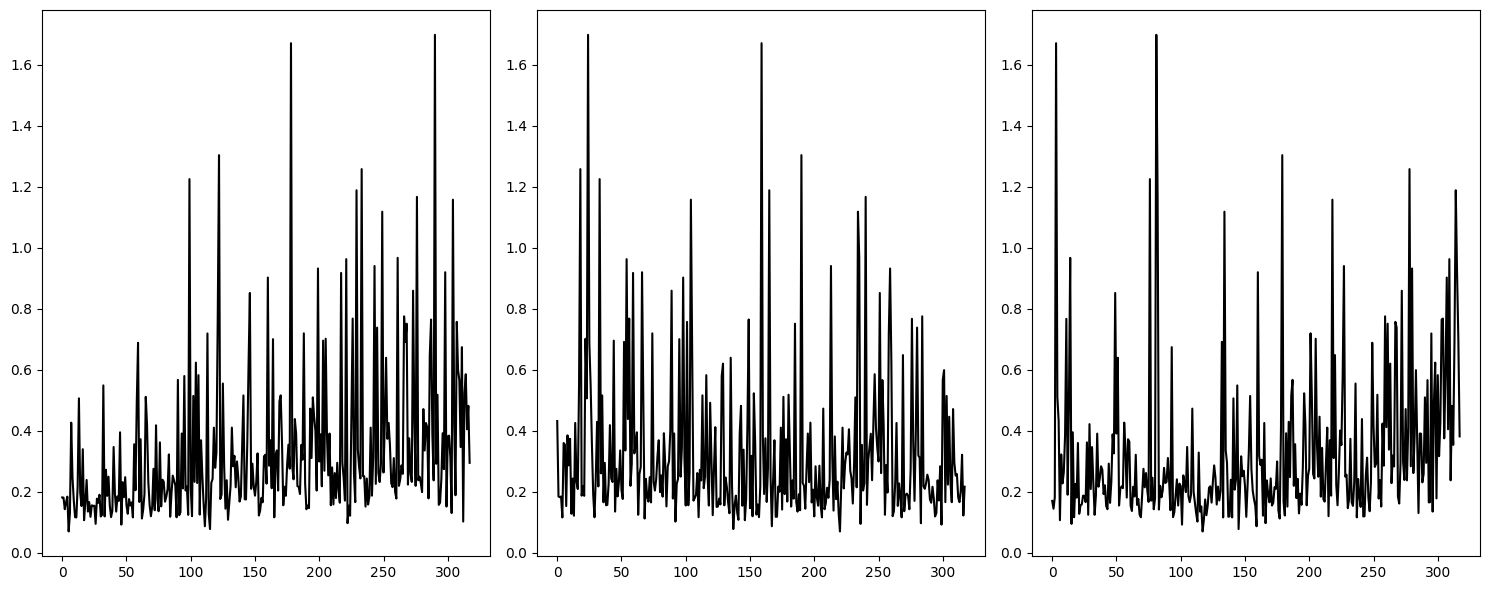

In [ ]:
fr_ratio = df[df['group'] == 'control']['information_target_session'].values
fr_change = df[df['group'] == 'control']['fr_change'].values
temporal_emd = df[df['group'] == 'control']['emd_quantile'].values
whole_emd = df[df['group'] == 'control']['quantile'].values
spike_density_emd = df[df['group'] == 'control']['sd_quantile'].values

temporal_order = np.argsort(temporal_emd)
whole_order = np.argsort(whole_emd)
spike_density_order = np.argsort(spike_density_emd)

fig = plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 3, 1)
ax.plot(np.arange(len(fr_ratio)), fr_ratio[temporal_order], label='fr_ratio', color='k')
running_avg = np.convolve(fr_ratio[temporal_order], np.ones((10,))/10, mode='valid')
# ax.plot(running_avg, label='running_avg', color='r')

ax = plt.subplot(1, 3, 2)
ax.plot(np.arange(len(fr_ratio)), fr_ratio[whole_order], label='fr_ratio', color='k')
running_avg = np.convolve(fr_ratio[whole_order], np.ones((10,))/10, mode='valid')
# ax.plot(running_avg, label='running_avg', color='r')


ax = plt.subplot(1, 3, 3)
ax.plot(np.arange(len(fr_ratio)), fr_ratio[spike_density_order], label='fr_ratio', color='k')
running_avg = np.convolve(fr_ratio[spike_density_order], np.ones((10,))/10, mode='valid')
# ax.plot(running_avg, label='running_avg', color='r')

fig.tight_layout()
plt.show()


In [67]:
print(len(df_empty), len(df_new), len(df_old))

0 75324 51825


In [63]:
print(df_new['signature'])

0        ANT-119a-6_20170613-2450-noodor-noobject
1        ANT-119a-6_20170613-2450-noodor-noobject
2        ANT-119a-6_20170613-2450-noodor-noobject
3        ANT-119a-6_20170613-2450-noodor-noobject
4        ANT-119a-6_20170613-2450-noodor-noobject
                           ...                   
75319                                         nan
75320                                         nan
75321                                         nan
75322                                         nan
75323                                         nan
Name: signature, Length: 75324, dtype: object


In [52]:
# df1 = pd.read_csv(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\testing1234.csv')
# df2 = pd.read_csv(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\testing123.csv')
# print(len(df1), len(df2))
# keys_to_check = ['group', 'name', 'depth', 'date', 'tetrode', 'unit_id']
# df1_keys = df1[keys_to_check]
# df2_keys = df2[keys_to_check]
# ct = 0
# for row in df1_keys.iterrows():
#     ky = tuple(row[1])
#     if ky not in df2_keys.values:
#         print(ky)
#         ct += 1
# print(ct)



2741 3051
0


In [47]:
df1_keys

,group,name,depth,date,tetrode,unit_id
0,ANT,ANT-119a-6,2450.0,20170613.0,1.0,2.0
1,ANT,ANT-119a-6,2450.0,20170613.0,1.0,3.0
2,ANT,ANT-119a-6,2450.0,20170613.0,1.0,3.0
3,ANT,ANT-119a-6,2450.0,20170613.0,5.0,2.0
4,ANT,ANT-119a-6,2450.0,20170613.0,5.0,3.0
...,...,...,...,...,...,...
2736,ANT,ANT-120-4,2400.0,20170613.0,5.0,4.0
2737,ANT,ANT-120-4,2400.0,20170613.0,5.0,4.0
2738,ANT,ANT-120-4,2400.0,20170613.0,5.0,4.0
2739,ANT,ANT-120-4,2400.0,20170613.0,5.0,4.0


In [ ]:
same_c = 0 
diff_c = 0
for l in all_ambig:
    isMatched = False
    for l2 in all_unmatched:
        if l == l2:
            isMatched = True
    if isMatched:
        same_c += 1
    else:
        diff_c += 1

print(same_c, diff_c)


In [ ]:
plt.hist(all_diffs, np.arange(0, 1, 0.01))
plt.show()

In [ ]:
# drop when field and centroid are in different directions
# df = df_all_matched_field.copy()

In [ ]:
print(len(all_unambig), len(all_ambig))
print(len(all_matched), len(all_unmatched))

In [ ]:
group_by_unique_cell = ['group', 'name', 'depth', 'date','tetrode', 'unit_id']

object_cell_df = df[df['score'] == score]
object_cell_df = object_cell_df[object_cell_df['session_id'].isin(['session_1','session_2','session_3'])]   
# 'session_4','session_5','session_6'])]

group_by_unique_cell_field = ['group', 'name', 'depth', 'date','tetrode', 'unit_id', 'field_id']

ANT_df = object_cell_df[object_cell_df['group'] == 'ANT'].reset_index(drop=True)
B6_df = object_cell_df[object_cell_df['group'] == 'B6'].reset_index(drop=True)
NON_df = object_cell_df[object_cell_df['group'] == 'NON'].reset_index(drop=True)

ANT_object_cell_df = ANT_df.copy() 
B6_object_cell_df = B6_df.copy() 
NON_object_cell_df = NON_df.copy() 
ANT_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
B6_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
NON_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
ANT_object_cell_df['cell_type'] = 'unassigned'
B6_object_cell_df['cell_type'] = 'unassigned'
NON_object_cell_df['cell_type'] = 'unassigned'
ANT_object_cell_df['isTrace'] = 0
B6_object_cell_df['isTrace'] = 0
NON_object_cell_df['isTrace'] = 0
ANT_object_cell_df['isObject'] = 0
B6_object_cell_df['isObject'] = 0
NON_object_cell_df['isObject'] = 0
ANT_object_cell_df['trace_a'] = None
B6_object_cell_df['trace_a'] = None
NON_object_cell_df['trace_a'] = None


ANT_object_cell_df.loc[ANT_object_cell_df['obj_a'].astype(str)  == ANT_object_cell_df['object_location'].astype(str),'isObject'] = 1
B6_object_cell_df.loc[B6_object_cell_df['obj_a'].astype(str)  == B6_object_cell_df['object_location'].astype(str),'isObject'] = 1
NON_object_cell_df.loc[NON_object_cell_df['obj_a'].astype(str)  == NON_object_cell_df['object_location'].astype(str),'isObject'] = 1

keep_trace_appearances = []
for df_touse in [ANT_object_cell_df, B6_object_cell_df, NON_object_cell_df]:
    prev_angles = []
    prev_unit_id = None
    prev_field_id = None
    prev_tetrode = None
    prev_name = None
    prev_date = None
    prev_depth = None
    to_keep_trace_appearance = []
    for i, row in df_touse.iterrows():
        curr_unit_id = row['unit_id']
        curr_tetrode = row['tetrode']
        curr_field_id = row['field_id']
        curr_angle = row['obj_a']
        curr_name = row['name']
        curr_date = row['date']
        curr_depth = row['depth']

        if curr_unit_id == prev_unit_id and curr_field_id == prev_field_id and curr_tetrode == prev_tetrode and curr_name == prev_name and curr_date == prev_date and curr_depth == prev_depth:
            if str(curr_angle) in prev_angles:
                to_keep_trace_appearance.append(i)
        else:
            prev_angles = []

        prev_unit_id = curr_unit_id
        prev_angle = curr_angle
        prev_field_id = curr_field_id
        prev_tetrode = curr_tetrode
        prev_name = curr_name
        prev_date = curr_date
        prev_depth = curr_depth
        prev_angles.append(row['object_location'])

    keep_trace_appearances.append(to_keep_trace_appearance)

ANT_object_cell_df.loc[keep_trace_appearances[0],'isTrace'] = 1
B6_object_cell_df.loc[keep_trace_appearances[1],'isTrace'] = 1
NON_object_cell_df.loc[keep_trace_appearances[2],'isTrace'] = 1

In [ ]:
import copy

group_by_unique_cell_session = ['group', 'name', 'depth', 'date', 'tetrode', 'unit_id','session_id'] # (joins field rowsfrom that ses)

ses_cut_dict = {}

for ses_cut in [3,4,5,6]:

    center_type_dict = {'ANT': 0,
                    'B6':0,
                    'NON': 0}

    center_inv_type_dict = {'ANT': 0,
                    'B6':0,
                    'NON': 0}

    quality_type_dict = {'ANT': 0,
                    'B6':0,
                    'NON': 0}   

    quality_inv_type_dict = {'ANT': 0,
                    'B6':0,
                    'NON': 0}           

    ambiguous_type_dict = {'ANT': 0,
                    'B6':0,
                    'NON': 0}       

    ambiguous_inv_type_dict = {'ANT': 0,
                    'B6':0,
                    'NON': 0}

    ses_cut_dict[ses_cut] = {}
    ANT_object_cell_df_to_use = ANT_object_cell_df[ANT_object_cell_df['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
    B6_object_cell_df_to_use = B6_object_cell_df[B6_object_cell_df['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
    NON_object_cell_df_to_use = NON_object_cell_df[NON_object_cell_df['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
    df_all_unmatched_field_to_use = df_all_unmatched_field[df_all_unmatched_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
    df_all_matched_field_to_use = df_all_matched_field[df_all_matched_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
    # df_all_unmatched_field_to_use = df_all_ambiguous_field[df_all_ambiguous_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
    # df_all_matched_field_to_use = df_all_unambiguous_field[df_all_unambiguous_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
    c = 0
    for df_current in [ANT_object_cell_df_to_use, B6_object_cell_df_to_use, NON_object_cell_df_to_use]:
        quality_dropped_identifiers = df_current[df_current['iso_dist'] < 5].groupby(group_by_unique_cell_session).groups.keys()
        quality_non_dropped_identifiers = df_current[df_current['iso_dist'] >= 5].groupby(group_by_unique_cell_session).groups.keys()
        center_dropped_identifiers = df_current[df_current['obj_q_NO'] < df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
        center_non_dropped_identifiers = df_current[df_current['obj_q_NO'] >= df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
        ambiguous_dropped_identifiers = df_all_unmatched_field_to_use[df_all_unmatched_field_to_use['group'] == ['ANT','B6','NON'][c]].groupby(group_by_unique_cell_session).groups.keys()
        ambiguous_non_dropped_identifiers = df_all_matched_field_to_use[df_all_matched_field_to_use['group'] == ['ANT','B6','NON'][c]].groupby(group_by_unique_cell_session).groups.keys()
        # mask_dropped = pd.concat([(df_current['group'] == id1) & (df_current['name'] == id2) & (df_current['depth'] == id3) & (df_current['date'] == id4) & (df_current['tetrode'] == id5) & (df_current['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in ambiguous_dropped_identifiers], axis=1).any(axis=1)
        # mask_non_dropped = pd.concat([(df_current['group'] == id1) & (df_current['name'] == id2) & (df_current['depth'] == id3) & (df_current['date'] == id4) & (df_current['tetrode'] == id5) & (df_current['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in ambiguous_non_dropped_identifiers], axis=1).any(axis=1)
        if c == 0:
            quality_type_dict['ANT'] = len(quality_dropped_identifiers)
            quality_inv_type_dict['ANT'] = len(quality_non_dropped_identifiers)
            center_type_dict['ANT'] = len(center_dropped_identifiers)
            center_inv_type_dict['ANT'] = len(center_non_dropped_identifiers)
            ambiguous_type_dict['ANT'] = len(ambiguous_dropped_identifiers)
            ambiguous_inv_type_dict['ANT'] = len(ambiguous_non_dropped_identifiers)
        elif c == 1:
            quality_type_dict['B6'] = len(quality_dropped_identifiers)
            quality_inv_type_dict['B6'] = len(quality_non_dropped_identifiers)
            center_type_dict['B6'] = len(center_dropped_identifiers)
            center_inv_type_dict['B6'] = len(center_non_dropped_identifiers)
            ambiguous_type_dict['B6'] = len(ambiguous_dropped_identifiers)
            ambiguous_inv_type_dict['B6'] = len(ambiguous_non_dropped_identifiers)
        elif c == 2:
            quality_type_dict['NON'] = len(quality_dropped_identifiers)
            quality_inv_type_dict['NON'] = len(quality_non_dropped_identifiers)
            center_type_dict['NON'] = len(center_dropped_identifiers)
            center_inv_type_dict['NON'] = len(center_non_dropped_identifiers)
            ambiguous_type_dict['NON'] = len(ambiguous_dropped_identifiers)
            ambiguous_inv_type_dict['NON'] = len(ambiguous_non_dropped_identifiers)

        c += 1
    ses_cut_dict[ses_cut]['quality_type_dict'] = copy.deepcopy(quality_type_dict)
    ses_cut_dict[ses_cut]['quality_inv_type_dict'] = copy.deepcopy(quality_inv_type_dict)
    ses_cut_dict[ses_cut]['center_type_dict'] = copy.deepcopy(center_type_dict)
    ses_cut_dict[ses_cut]['center_inv_type_dict'] = copy.deepcopy(center_inv_type_dict)
    ses_cut_dict[ses_cut]['ambiguous_type_dict'] = copy.deepcopy(ambiguous_type_dict)
    ses_cut_dict[ses_cut]['ambiguous_inv_type_dict'] = copy.deepcopy(ambiguous_inv_type_dict)

c = 0
for df_current in [ANT_object_cell_df, B6_object_cell_df, NON_object_cell_df]:


    # filter out rows where iso_dist is < 5 - Quality control
    quality_dropped_identifiers = df_current[df_current['iso_dist'] < 5].groupby(group_by_unique_cell_session).groups.keys()
    quality_non_dropped_identifiers = df_current[df_current['iso_dist'] >= 5].groupby(group_by_unique_cell_session).groups.keys()
    df_current = df_current[df_current['iso_dist'] >= 5]

    # filter out rows where obj_q_NO is < obj_q - CLOSER to middle than a side
    center_dropped_identifiers = df_current[df_current['obj_q_NO'] < df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
    center_non_dropped_identifiers = df_current[df_current['obj_q_NO'] >= df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
    df_current = df_current[df_current['obj_q_NO'] >= df_current['obj_q']] 
    """ HAVE TO RE RUN ALL U HAD THIS LINE AS /3, need ot check combos of ambiguous classic and mbiuous theshold 0.05 """

    # filter out rows where obj_a for centroid is != obj_a for field - Ambiguous
    ambiguous_dropped_identifiers = df_all_unmatched_field.groupby(group_by_unique_cell_session).groups.keys()
    # ambiguous_dropped_identifiers = df_all_ambiguous_field.groupby(group_by_unique_cell_session).groups.keys()
    mask = pd.concat([(df_current['group'] == id1) & (df_current['name'] == id2) & (df_current['depth'] == id3) & (df_current['date'] == id4) & (df_current['tetrode'] == id5) & (df_current['unit_id'] == id6 & (df_current['session_id'] == id7)) for id1, id2, id3, id4, id5, id6, id7 in ambiguous_dropped_identifiers], axis=1).any(axis=1)
    df_current = df_current[~mask]

    # # filter out > 3 fields
    # field_dropped_identifiers = df_current[df_current['field_id'] > 3].groupby(group_by_unique_cell).groups.keys()
    # df_current = df_current[df_current['field_id'] <= 3]

    # filter out less than 2 sessions
    remaining_session_dropped_identifiers = df_current.groupby(group_by_unique_cell).filter(lambda x: len(x) < 2).groupby(group_by_unique_cell).groups.keys()
    df_current = df_current.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2)

    if c == 0:
        ANT_object_cell_df = df_current
    elif c == 1:
        B6_object_cell_df = df_current
    elif c == 2:
        NON_object_cell_df = df_current

    c += 1  
    
ANT_cell_type_df = ANT_object_cell_df.copy()
B6_cell_type_df = B6_object_cell_df.copy()
NON_cell_type_df = NON_object_cell_df.copy()

In [ ]:
ses_cut = 3
print('Cell-session appearances are low quality from ANT: {}, B6: {}, NON: {}'.format(ses_cut_dict[ses_cut]['quality_type_dict']['ANT'], ses_cut_dict[ses_cut]['quality_type_dict']['B6'], ses_cut_dict[ses_cut]['quality_type_dict']['NON']))
print('Cell-session appearances are closer to the center from ANT: {}, B6: {}, NON: {}'.format(ses_cut_dict[ses_cut]['center_type_dict']['ANT'], ses_cut_dict[ses_cut]['center_type_dict']['B6'], ses_cut_dict[ses_cut]['center_type_dict']['NON']))
print('Cell-session appearances are ambiguous to angle from ANT: {}, B6: {}, NON: {}'.format(ses_cut_dict[ses_cut]['ambiguous_type_dict']['ANT'], ses_cut_dict[ses_cut]['ambiguous_type_dict']['B6'], ses_cut_dict[ses_cut]['ambiguous_type_dict']['NON']))
# print('Cells dropped due to field from ANT: {}, B6: {}, NON: {}'.format(ses_cut_dict[ses_cut]['field_type_dict']['ANT'], ses_cut_dict[ses_cut]['field_type_dict']['B6'], ses_cut_dict[ses_cut]['field_type_dict']['NON']))

print('\n')

print(len(ANT_cell_type_df.groupby(group_by_unique_cell_session).groups.keys()), ' remaining ANT cell-session appearances that are part of a cell with >=2 sessions')
print(len(B6_cell_type_df.groupby(group_by_unique_cell_session).groups.keys()), ' remaining B6 cell-session appearances that are part of a cell with >=2 sessions')
print(len(NON_cell_type_df.groupby(group_by_unique_cell_session).groups.keys()), ' remaining NON cell-session appearances that are part of a cell with >=2 sessions')


In [ ]:
# object_cell_df = df[df['score'] == score]
# object_cell_df = object_cell_df[object_cell_df['session_id'].isin(['session_1','session_2','session_3'])]
# centroid_cell_df = df[df['score'] == 'centroid']

# object_cell_df = object_cell_df[object_cell_df['object_location'].astype(str) != 'NO']
# object_cell_df = object_cell_df.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2)

# if main_field_only:
#     object_cell_df = object_cell_df[object_cell_df['field_id'] == 1]
#     centroid_cell_df = centroid_cell_df[centroid_cell_df['field_id'] == 1]

# # Split by group
# group_by_unique_cell_field = ['group', 'name', 'depth', 'date','tetrode', 'unit_id', 'field_id']

# ANT_df = object_cell_df[object_cell_df['group'] == 'ANT'].reset_index(drop=True)
# B6_df = object_cell_df[object_cell_df['group'] == 'B6'].reset_index(drop=True)
# NON_df = object_cell_df[object_cell_df['group'] == 'NON'].reset_index(drop=True)
# centroid_ANT_df = centroid_cell_df[centroid_cell_df['group'] == 'ANT'].reset_index(drop=True)
# centroid_B6_df = centroid_cell_df[centroid_cell_df['group'] == 'B6'].reset_index(drop=True)
# centroid_NON_df = centroid_cell_df[centroid_cell_df['group'] == 'NON'].reset_index(drop=True)

# # ANT_object_cell_df = ANT_df[ANT_df['obj_q'] <= ANT_df['field_coverage']].reset_index(drop=True)
# # B6_object_cell_df = B6_df[B6_df['obj_q'] <= B6_df['field_coverage']].reset_index(drop=True)
# # NON_object_cell_df = NON_df[NON_df['obj_q'] <= NON_df['field_coverage']].reset_index(drop=True)
# ANT_object_cell_df = ANT_df.copy() 
# B6_object_cell_df = B6_df.copy() 
# NON_object_cell_df = NON_df.copy() 
# ANT_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
# B6_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
# NON_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
# ANT_object_cell_df['cell_type'] = 'unassigned'
# B6_object_cell_df['cell_type'] = 'unassigned'
# NON_object_cell_df['cell_type'] = 'unassigned'
# ANT_object_cell_df['isTrace'] = 0
# B6_object_cell_df['isTrace'] = 0
# NON_object_cell_df['isTrace'] = 0
# ANT_object_cell_df['isObject'] = 0
# B6_object_cell_df['isObject'] = 0
# NON_object_cell_df['isObject'] = 0
# ANT_object_cell_df['trace_a'] = None
# B6_object_cell_df['trace_a'] = None
# NON_object_cell_df['trace_a'] = None

# ANT_object_cell_df.loc[ANT_object_cell_df['obj_a'].astype(str)  == ANT_object_cell_df['object_location'].astype(str),'isObject'] = 1
# B6_object_cell_df.loc[B6_object_cell_df['obj_a'].astype(str)  == B6_object_cell_df['object_location'].astype(str),'isObject'] = 1
# NON_object_cell_df.loc[NON_object_cell_df['obj_a'].astype(str)  == NON_object_cell_df['object_location'].astype(str),'isObject'] = 1
# print(len(ANT_object_cell_df[ANT_object_cell_df['cell_type'] == 'object']))

# # B6_object_cell_df = B6_object_cell_df[B6_object_cell_df['obj_a'].astype(str) == B6_object_cell_df['object_location'].astype(str) ]
# # NON_object_cell_df = NON_object_cell_df[NON_object_cell_df['obj_a'].astype(str)  == NON_object_cell_df['object_location'].astype(str) ]
# # ANT_object_cell_df = ANT_df 
# # B6_object_cell_df = B6_df
# # NON_object_cell_df = NON_df

# keep_ids = []
# keep_ids2 = []
# keep_ids3 = []
# keep_ids4 = []
# keep_prev_locs = []
# keep_trace_appearances = []
# # keep_ids5 = []
# for df_touse in [ANT_object_cell_df, B6_object_cell_df, NON_object_cell_df]:
#     prev_unit_id = None
#     prev_angle = None
#     prev_loc = None
#     prev_loc_2 = None
#     pair_count = 0
#     cell_passed = False
#     to_keep = []
#     to_keep2 = []
#     to_keep3 = []
#     to_keep4 = []
#     to_keep_prev_locs = []
#     to_keep_trace_appearance = []
#     prev_angles = []
#     # to_keep5 = []
#     for i, row in df_touse.iterrows():
#         curr_unit_id = row['unit_id']
#         curr_tetrode = row['tetrode']
#         curr_field_id = row['field_id']
#         curr_angle = row['obj_a']
#         curr_name = row['name']
#         curr_date = row['date']
#         curr_depth = row['depth']

#         if curr_unit_id == prev_unit_id and curr_field_id == prev_field_id and curr_tetrode == prev_tetrode and curr_name == prev_name and curr_date == prev_date and curr_depth == prev_depth:
#             if str(curr_angle) in prev_angles:
#                 to_keep_trace_appearance.append(i)
        
#         # if curr_unit_id == prev_unit_id and curr_field_id == prev_field_id and curr_tetrode == prev_tetrode and curr_name == prev_name and curr_date == prev_date and curr_depth == prev_depth:
#         #     if curr_angle == prev_angle:
#         #         # pass # has remapped, is ok 
#         #         to_keep3.append(i)

#         #     if str(curr_angle) == str(prev_loc) and str(prev_loc) != str(row['object_location']):
#         #         to_keep.append(i)  
#         #         to_keep_prev_locs.append(str(prev_loc))

#         # if curr_unit_id == prev_unit_id and prev_loc_2 is not None and curr_field_id == prev_field_id and curr_tetrode == prev_tetrode and curr_name == prev_name and curr_date == prev_date and curr_depth == prev_depth:
#         #     if str(curr_angle) == str(prev_loc_2) and str(prev_loc) != str(prev_loc_2) and str(curr_angle) != str(prev_loc) and str(curr_angle) != str(prev_angle) and str(curr_angle) != str(row['object_location']):
#         #         to_keep2.append(i) 


#         # if curr_unit_id == prev_unit_id and curr_field_id == prev_field_id and curr_tetrode == prev_tetrode and curr_name == prev_name and curr_date == prev_date and curr_depth == prev_depth:
#         #     if str(curr_angle) != str(prev_loc_2) and str(curr_angle) != str(prev_loc) and str(curr_angle) != str(prev_angle) and str(curr_angle) != str(row['object_location']):
#         #         assert i not in to_keep3 
#         #         assert i not in to_keep
#         #         assert i not in to_keep2
#         #         to_keep4.append(i)  
       

#         if curr_unit_id != prev_unit_id or curr_field_id != prev_field_id or curr_tetrode != prev_tetrode or curr_name != prev_name or curr_date != prev_date or curr_depth != prev_depth:
#             prev_angles = []
#             if i != 0:
#                 prev_loc_2 = None

#         if prev_loc is not None: 
#             prev_loc_2 = prev_loc

#         prev_loc = row['object_location']
#         prev_unit_id = curr_unit_id
#         prev_angle = curr_angle
#         prev_field_id = curr_field_id
#         prev_tetrode = curr_tetrode
#         prev_name = curr_name
#         prev_date = curr_date
#         prev_depth = curr_depth
#         prev_angles.append(str(prev_loc))

#     keep_ids.append(np.unique(to_keep))
#     keep_ids2.append(np.unique(to_keep2))
#     keep_ids3.append(np.unique(to_keep3))
#     keep_ids4.append(np.unique(to_keep4))
#     keep_prev_locs.append(to_keep_prev_locs)
#     keep_trace_appearances.append(to_keep_trace_appearance)
#     # keep_ids5.append(np.unique(to_keep5))

# # # very important unassigned set first
# # ANT_object_cell_df.loc[keep_ids4[0],'cell_type'] = 'unassigned'
# # B6_object_cell_df.loc[keep_ids4[1],'cell_type'] = 'unassigned'
# # NON_object_cell_df.loc[keep_ids4[2],'cell_type'] = 'unassigned'

# # do not uncomment, will override object cells

# # ANT_object_cell_df.loc[keep_ids3[0],'cell_type'] = 'stable'
# # B6_object_cell_df.loc[keep_ids3[1],'cell_type'] = 'stable'
# # NON_object_cell_df.loc[keep_ids3[2],'cell_type'] = 'stable'

# # ANT_object_cell_df.loc[keep_ids[0],'cell_type'] = 'trace'
# # B6_object_cell_df.loc[keep_ids[1],'cell_type'] = 'trace'
# # NON_object_cell_df.loc[keep_ids[2],'cell_type'] = 'trace'
# ANT_object_cell_df.loc[keep_ids[0],'trace_a'] = keep_prev_locs[0]
# B6_object_cell_df.loc[keep_ids[1],'trace_a'] = keep_prev_locs[1]
# NON_object_cell_df.loc[keep_ids[2],'trace_a'] = keep_prev_locs[2]

# ANT_object_cell_df.loc[keep_trace_appearances[0],'isTrace'] = 1
# B6_object_cell_df.loc[keep_trace_appearances[1],'isTrace'] = 1
# NON_object_cell_df.loc[keep_trace_appearances[2],'isTrace'] = 1

# # print(len(ANT_object_cell_df[ANT_object_cell_df['cell_type'] == 'object']))

# # ANT_object_cell_df.loc[keep_ids2[0],'cell_type'] = 'trace'
# # B6_object_cell_df.loc[keep_ids2[1],'cell_type'] = 'trace'
# # NON_object_cell_df.loc[keep_ids2[2],'cell_type'] = 'trace'

# # print(len(ANT_object_cell_df[ANT_object_cell_df['cell_type'] == 'object']))

# # ANT_object_cell_df.loc[keep_ids5[0],'cell_type'] = 'object'
# # B6_object_cell_df.loc[keep_ids5[1],'cell_type'] = 'object'
# # NON_object_cell_df.loc[keep_ids5[2],'cell_type'] = 'object'


# ANT_cell_type_df = ANT_object_cell_df.copy()
# B6_cell_type_df = B6_object_cell_df.copy()
# NON_cell_type_df = NON_object_cell_df.copy()

# # ANT_object_cell_df = ANT_object_cell_df.iloc[keep_ids[0]]
# # B6_object_cell_df = B6_object_cell_df.iloc[keep_ids[1]]
# # NON_object_cell_df = NON_object_cell_df.iloc[keep_ids[2]]
# # ANT_object_cell_df = ANT_object_cell_df[ANT_object_cell_df['cell_type'] == 'object']
# # B6_object_cell_df = B6_object_cell_df[B6_object_cell_df['cell_type'] == 'object']
# # NON_object_cell_df = NON_object_cell_df[NON_object_cell_df['cell_type'] == 'object']

# ANT_object_cell_df = ANT_object_cell_df[ANT_object_cell_df['isObject'] == 1]
# B6_object_cell_df = B6_object_cell_df[B6_object_cell_df['isObject'] == 1]
# NON_object_cell_df = NON_object_cell_df[NON_object_cell_df['isObject'] == 1]

# # print(len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'trace']))
# # print(len(ANT_object_cell_df[ANT_object_cell_df['cell_type'] == 'trace']))



# # get idx of cells with object width < 15
# # idx = centroid_ANT_df[centroid_ANT_df['obj_w'] <= 4].index
# # ANT_object_cell_df = ANT_df.iloc[idx]
# # idx = centroid_B6_df[centroid_B6_df['obj_w'] <= 4].index
# # B6_object_cell_df = B6_df.iloc[idx]
# # idx = centroid_NON_df[centroid_NON_df['obj_w'] <= 4].index
# # NON_object_cell_df = NON_df.iloc[idx]

# # ANT_object_cell_df = ANT_object_cell_df[ANT_object_cell_df['obj_q'] < 0.1]
# # B6_object_cell_df = B6_object_cell_df[B6_object_cell_df['obj_q'] < 0.1]
# # NON_object_cell_df = NON_object_cell_df[NON_object_cell_df['obj_q'] < 0.1]

# # ANT_object_cell_df = ANT_df[ANT_df['field_coverage'] < 0.2]
# # B6_object_cell_df = B6_df[B6_df['field_coverage'] < 0.2]
# # NON_object_cell_df = NON_df[NON_df['field_coverage'] < 0.2]

# # ANT_object_cell_df = ANT_object_cell_df[ANT_object_cell_df['obj_q'] < ANT_object_cell_df['field_coverage']]
# # B6_object_cell_df = B6_object_cell_df[B6_object_cell_df['obj_q'] < B6_object_cell_df['field_coverage']]
# # NON_object_cell_df = NON_object_cell_df[NON_object_cell_df['obj_q'] < NON_object_cell_df['field_coverage']]

# # Must be over X consecutive sessions
# # group_by = ['name','tetrode','unit_id','date', 'field_id']
# group_by = None
# group_by_unique_cell_field = ['group', 'name', 'depth', 'date','tetrode', 'unit_id', 'field_id']
# group_by_unique_cell = ['group', 'name', 'depth', 'date','tetrode', 'unit_id']
# from itertools import count

# def filter_consecutive_sessions(group):
#     session_ids = group['session_id'].str.split('_').str[-1]
#     prev_session_id = None
#     count = 0
    
#     for session_id in session_ids:
#         if prev_session_id is None:
#             count = 1
#         elif int(session_id) - int(prev_session_id) == 1:
#             count += 1
#         else:
#             count = 1
#         prev_session_id = session_id
        
#         if count >= consecutive_sessions_threshold:
#             return True
    
#     return False

# if not consecutive:
#     sporadic_ANT_object_cell_df = ANT_object_cell_df.groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2)
#     sporadic_B6_object_cell_df = B6_object_cell_df.groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2)
#     sporadic_NON_object_cell_df = NON_object_cell_df.groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2)

# ANT_object_cell_df = ANT_object_cell_df.groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions)
# B6_object_cell_df = B6_object_cell_df.groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions)
# NON_object_cell_df = NON_object_cell_df.groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions)
# # ANT_object_cell_df  = sporadic_ANT_object_cell_df
# # B6_object_cell_df  = sporadic_B6_object_cell_df
# # NON_object_cell_df  = sporadic_NON_object_cell_df

# print('There are {} object cells in ANT'.format(len(ANT_object_cell_df.groupby(group_by_unique_cell))))
# print('There are {} object cells in B6'.format(len(B6_object_cell_df.groupby(group_by_unique_cell))))
# print('There are {} object cells in NON'.format(len(NON_object_cell_df.groupby(group_by_unique_cell))))

# sum_ANT = ANT_df[ANT_df['object_location'].astype(str) != 'NO']
# sum_ANT = sum_ANT.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
# sum_ANT = len(sum_ANT)
# sum_B6 = B6_df[B6_df['object_location'].astype(str) != 'NO']
# sum_B6 = sum_B6.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
# sum_B6 = len(sum_B6)
# sum_NON = NON_df[NON_df['object_location'].astype(str) != 'NO']
# sum_NON = sum_NON.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
# sum_NON = len(sum_NON)
# # sum_ANT = len(ANT_df.groupby(group_by))
# # sum_B6 = len(B6_df.groupby(group_by))
# # sum_NON = len(NON_df.groupby(group_by))

# antP = len(ANT_object_cell_df.groupby(group_by_unique_cell)) / sum_ANT * 100
# b6P = len(B6_object_cell_df.groupby(group_by_unique_cell)) / sum_B6 * 100
# nonP = len(NON_object_cell_df.groupby(group_by_unique_cell)) / sum_NON * 100
# print('{}% of ANT cells are object cells out of {} available cells'.format(antP,sum_ANT))
# print('{}% of B6 cells are object cells out of {} available cells'.format(b6P, sum_B6))
# print('{}% of NON cells are object cells out of {} available cells'.format(nonP, sum_NON))

# # ANT vs B6 chi squared test
# from scipy.stats import chi2_contingency
# from scipy.stats import chi2

# expected_freq = (antP + nonP) / 100 * (sum_ANT + sum_NON)
# assert expected_freq > 5, 'Expected frequency is less than 5, it is {}'.format(expected_freq)

# observed_freq = len(ANT_object_cell_df.groupby(group_by_unique_cell)) + len(NON_object_cell_df.groupby(group_by_unique_cell))
# chi, p, dof, expected = chi2_contingency([[len(ANT_object_cell_df.groupby(group_by_unique_cell)), len(NON_object_cell_df.groupby(group_by_unique_cell))],
#                                             [sum_ANT - len(ANT_object_cell_df.groupby(group_by_unique_cell)), sum_NON - len(NON_object_cell_df.groupby(group_by_unique_cell))]])
# print('ANT vs NON chi squared test')
# print('chi = {}, p = {}, dof = {}'.format(chi, p, dof))
# print('expected = {}'.format(expected))

# fig, ax = plt.subplots(figsize=(8, 5))
# groups = ['ANT', 'NON', 'B6']
# bar_width = 0.35
# # Main bars
# percentages_main = [len(ANT_object_cell_df.groupby(group_by_unique_cell)) / sum_ANT * 100,
#                len(NON_object_cell_df.groupby(group_by_unique_cell)) / sum_NON * 100,
#                len(B6_object_cell_df.groupby(group_by_unique_cell)) / sum_B6 * 100]
# # main_bars = ax.bar(np.arange(len(groups)), percentages_main, bar_width, color='k', alpha=1)
# in_ANT = len(ANT_object_cell_df[ANT_object_cell_df['obj_q'] <= ANT_object_cell_df['field_coverage']]) / len(ANT_object_cell_df.groupby(group_by_unique_cell)) * percentages_main[0]
# in_NON = len(NON_object_cell_df[NON_object_cell_df['obj_q'] <= NON_object_cell_df['field_coverage']]) / len(NON_object_cell_df.groupby(group_by_unique_cell)) * percentages_main[1]
# in_B6 = len(B6_object_cell_df[B6_object_cell_df['obj_q'] <= B6_object_cell_df['field_coverage']]) / len(B6_object_cell_df.groupby(group_by_unique_cell)) * percentages_main[2]
# in_field_prop = [ in_ANT / sum_ANT * 100,
#                     in_NON / sum_NON * 100,
#                     in_B6 / sum_B6 * 100]
# out_field_prop = [percentages_main[0] - in_field_prop[0],
#                     percentages_main[1] - in_field_prop[1],
#                     percentages_main[2] - in_field_prop[2]]
# b1 = ax.bar(np.arange(len(groups)), in_field_prop, bar_width, color='k', alpha=1, label='In-field')
# b2 = ax.bar(np.arange(len(groups)), out_field_prop, bar_width, color='k', alpha=0.75, 
#             label='Out-field', bottom=in_field_prop)
# # Sporadic bars
# percentages_sporadic = [len(sporadic_ANT_object_cell_df.groupby(group_by_unique_cell)) / sum_ANT * 100,
#                         len(sporadic_NON_object_cell_df.groupby(group_by_unique_cell)) / sum_NON * 100,
#                         len(sporadic_B6_object_cell_df.groupby(group_by_unique_cell)) / sum_B6 * 100]
# in_sporadic_ANT = len(sporadic_ANT_object_cell_df[sporadic_ANT_object_cell_df['obj_q'] <= sporadic_ANT_object_cell_df['field_coverage']]) / len(sporadic_ANT_object_cell_df.groupby(group_by_unique_cell)) * percentages_sporadic[0]
# in_sporadic_NON = len(sporadic_NON_object_cell_df[sporadic_NON_object_cell_df['obj_q'] <= sporadic_NON_object_cell_df['field_coverage']]) / len(sporadic_NON_object_cell_df.groupby(group_by_unique_cell)) * percentages_sporadic[1]
# in_sporadic_B6 = len(sporadic_B6_object_cell_df[sporadic_B6_object_cell_df['obj_q'] <= sporadic_B6_object_cell_df['field_coverage']]) / len(sporadic_B6_object_cell_df.groupby(group_by_unique_cell)) * percentages_sporadic[2]
# in_field_prop_sporadic = [ in_sporadic_ANT / sum_ANT * 100,
#                     in_sporadic_NON / sum_NON * 100,
#                     in_sporadic_B6 / sum_B6 * 100]
# out_field_prop_sporadic = [percentages_sporadic[0] - in_field_prop_sporadic[0],
#                     percentages_sporadic[1] - in_field_prop_sporadic[1],
#                     percentages_sporadic[2] - in_field_prop_sporadic[2]]

# b3 = ax.bar(np.arange(len(groups)) + bar_width, in_field_prop_sporadic, bar_width, color='k', alpha=0.5)
# b4 = ax.bar(np.arange(len(groups)) + bar_width, out_field_prop_sporadic, bar_width, color='k', 
#             alpha=0.25, bottom=in_field_prop_sporadic)
# # sporadic_bars = ax.bar(np.arange(len(groups)) + bar_width, percentages_sporadic, bar_width, color='grey', alpha=1)
# # Connect the bars with a line
# ax.plot(np.arange(len(groups)), percentages_main, 'k-', marker='o', alpha=0.5)
# ax.plot(np.arange(len(groups)) + bar_width, percentages_sporadic, 'k-', marker='o', alpha=0.5)
# # Set the x-axis tick positions and labels
# ax.set_xticks(np.arange(len(groups)) + bar_width / 2)
# ax.set_xticklabels(groups)
# # Add legend
# ax.legend([b1, b2, b3, b4], ['Consecutive In-field', 'Consecutive Out-field', 'Sporadic In-field', 'Sporadic Out-field'])
# ax.set_ylabel('% of object cells')
# title = 'Object cells using {} distance'.format(score)
# ax.set_title(title)
# plt.show()

# fig = plt.figure(figsize=(6, 5))
# ax = fig.add_subplot(111)
# colors = ['r', 'g', 'b']
# angle_groups = [0, 90, 180, 270]
# bar_width = 0.1
# spacing = 0.1
# for i, obj_a in enumerate(angle_groups):
#     # obj_a = str(obj_a)
#     ANT_obj_a_df = ANT_object_cell_df[ANT_object_cell_df['obj_a'] == obj_a]
#     B6_obj_a_df = B6_object_cell_df[B6_object_cell_df['obj_a'] == obj_a]
#     NON_obj_a_df = NON_object_cell_df[NON_object_cell_df['obj_a'] == obj_a]
#     # ANT_obj_a_df = ANT_object_cell_df[ANT_object_cell_df['trace_a'] == obj_a]
#     # B6_obj_a_df = B6_object_cell_df[B6_object_cell_df['trace_a'] == obj_a]
#     # NON_obj_a_df = NON_object_cell_df[NON_object_cell_df['trace_a'] == obj_a]
#     # sum_ANT = len(ANT_df[ANT_df['obj_a'] == obj_a].groupby(group_by))
#     # sum_B6 = len(B6_df[B6_df['obj_a'] == obj_a].groupby(group_by))
#     # sum_NON = len(NON_df[NON_df['obj_a'] == obj_a].groupby(group_by))

#     if not consecutive:
#         sporadic_ANT_obj_a_df = ANT_obj_a_df.groupby(group_by_unique_cell).filter(lambda x: len(x) >= consecutive_sessions_threshold)
#         sporadic_B6_obj_a_df = B6_obj_a_df.groupby(group_by_unique_cell).filter(lambda x: len(x) >= consecutive_sessions_threshold)
#         sporadic_NON_obj_a_df = NON_obj_a_df.groupby(group_by_unique_cell).filter(lambda x: len(x) >= consecutive_sessions_threshold)
#     ANT_obj_a_df = ANT_obj_a_df.groupby(group_by_unique_cell).filter(filter_consecutive_sessions)
#     B6_obj_a_df = B6_obj_a_df.groupby(group_by_unique_cell).filter(filter_consecutive_sessions)
#     NON_obj_a_df = NON_obj_a_df.groupby(group_by_unique_cell).filter(filter_consecutive_sessions)
#     percentages = [len(ANT_obj_a_df.groupby(group_by_unique_cell)) / sum_ANT * 100,
#                    len(NON_obj_a_df.groupby(group_by_unique_cell)) / sum_NON * 100,
#                    len(B6_obj_a_df.groupby(group_by_unique_cell)) / sum_B6 * 100]
#     if not consecutive:
#         percentages_sporadic = [len(sporadic_ANT_obj_a_df.groupby(group_by_unique_cell)) / sum_ANT * 100,
#                                 len(sporadic_NON_obj_a_df.groupby(group_by_unique_cell)) / sum_NON * 100,
#                                 len(sporadic_B6_obj_a_df.groupby(group_by_unique_cell)) / sum_B6 * 100]
#     # Main bars
#     main_bars = ax.bar(np.arange(len(groups)) + i * (bar_width + spacing), percentages, bar_width, color=colors, alpha=1)

#     # Sporadic bars
#     if not consecutive:
#         sporadic_bars = ax.bar(np.arange(len(groups)) + i * (bar_width + spacing) + bar_width, percentages_sporadic, bar_width, color=colors, alpha=0.5)
# ax.legend([main_bars, sporadic_bars], ['Consecutive', 'Sporadic'])
# ax.set_xticks(np.arange(len(groups)) + (len(angle_groups) - 1) * (bar_width + spacing) / 2)
# ax.set_xticklabels(groups)

# ax.set_ylabel('% of object cells')
# title = 'Object cells using {} distance for angle order {}'.format(score, angle_groups)
# ax.set_title(title)
# fig.tight_layout()
# plt.show()

# fig, ax = plt.subplots(figsize=(6, 6))
# groups = ['ANT', 'NON', 'B6']
# data = []
# metric = 'obj_w'

# # Extract values from DataFrames
# for subdf in [ANT_object_cell_df, NON_object_cell_df, B6_object_cell_df]:
#     data.append(subdf[metric].values)  # Replace 'column_name' with the actual column name in your data

# # Create boxplots
# boxprops = dict(linewidth=1.5, color='k')
# flierprops = dict(marker='o', markersize=5, markerfacecolor='k', linestyle='none')
# whiskerprops = dict(linewidth=1.5, color='k')
# medianprops = dict(linewidth=2.5, color='r')
# ax.boxplot(data, positions=np.arange(len(groups)), patch_artist=True, boxprops=boxprops,
#            flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops)

# # Set the x-axis tick positions and labels
# ax.set_xticks(np.arange(len(groups)))
# ax.set_xticklabels(groups)
# # Set the y-axis label and title
# ax.set_ylabel(metric)
# title = 'Object cells using {} distance'.format(score)
# ax.set_title(title)

# plt.show()


# # # Split by session_id
# # for group in ['ANT', 'B6', 'NON']:
# #     for session_id in df[df['group'] == group]['session_id'].unique():
# #         session_df = df[(df['group'] == group) & (df['session_id'] == session_id)]
# #         object_cell_df = session_df[(session_df['score'] == 'field') & (session_df['field_id'] == 1) & (session_df['obj_q'] < 0.05)]

# #         print('There are {} object cells in {} {}'.format(len(object_cell_df), group, session_id))
# #         print('{}% of {} cells are object cells in {}'.format(len(object_cell_df) / len(session_df) * 100, group, session_id))
# #         print('')


In [ ]:
identifier_dict = {}

identifier_dict['object'] = {}
identifier_dict['trace'] = {}
identifier_dict['unassigned'] = {}

# identifier_dict['object']['ANT'] = list(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'object'].groupby(group_by_unique_cell).groups.keys())

identifier_dict['object']['ANT'] = list(ANT_cell_type_df[ANT_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell).groups.keys())
identifier_dict['object']['B6'] = list(B6_cell_type_df[B6_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell).groups.keys())
identifier_dict['object']['NON'] = list(NON_cell_type_df[NON_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell).groups.keys())
mask = pd.concat([(ANT_cell_type_df['group'] == id1) & (ANT_cell_type_df['name'] == id2) & (ANT_cell_type_df['depth'] == id3) & (ANT_cell_type_df['date'] == id4) & (ANT_cell_type_df['tetrode'] == id5) & (ANT_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['object']['ANT']], axis=1).any(axis=1)
ANT_cell_type_df.loc[mask,'cell_type'] = 'object'
mask = pd.concat([(B6_cell_type_df['group'] == id1) & (B6_cell_type_df['name'] == id2) & (B6_cell_type_df['depth'] == id3) & (B6_cell_type_df['date'] == id4) & (B6_cell_type_df['tetrode'] == id5) & (B6_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['object']['B6']], axis=1).any(axis=1)
B6_cell_type_df.loc[mask,'cell_type'] = 'object'
mask = pd.concat([(NON_cell_type_df['group'] == id1) & (NON_cell_type_df['name'] == id2) & (NON_cell_type_df['depth'] == id3) & (NON_cell_type_df['date'] == id4) & (NON_cell_type_df['tetrode'] == id5) & (NON_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['object']['NON']], axis=1).any(axis=1)
NON_cell_type_df.loc[mask,'cell_type'] = 'object'

filt = ANT_cell_type_df[ANT_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
first_set = filt[filt['isTrace'] == 1].groupby(group_by_unique_cell).groups.keys()
second_set = ANT_cell_type_df[(ANT_cell_type_df['isObject'] == 0) & (ANT_cell_type_df['isTrace'] == 1)].groupby(group_by_unique_cell).groups.keys()
# unq_set = set(first_set).difference(second_set)
unique_set = list(set(list(first_set) + list(second_set)))
unique_set = [x for x in unique_set if x not in identifier_dict['object']['ANT']]
identifier_dict['trace']['ANT'] = list(unique_set)
mask = pd.concat([(ANT_cell_type_df['group'] == id1) & (ANT_cell_type_df['name'] == id2) & (ANT_cell_type_df['depth'] == id3) & (ANT_cell_type_df['date'] == id4) & (ANT_cell_type_df['tetrode'] == id5) & (ANT_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['trace']['ANT']], axis=1).any(axis=1)
ANT_cell_type_df.loc[mask,'cell_type'] = 'trace'

filt = B6_cell_type_df[B6_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
first_set = filt[filt['isTrace'] == 1].groupby(group_by_unique_cell).groups.keys()
second_set = B6_cell_type_df[(B6_cell_type_df['isObject'] == 0) & (B6_cell_type_df['isTrace'] == 1)].groupby(group_by_unique_cell).groups.keys()
# unq_set = set(first_set).difference(second_set)
unique_set = list(set(list(first_set) + list(second_set)))
unique_set = [x for x in unique_set if x not in identifier_dict['object']['B6']]
identifier_dict['trace']['B6'] = list(unique_set)
mask = pd.concat([(B6_cell_type_df['group'] == id1) & (B6_cell_type_df['name'] == id2) & (B6_cell_type_df['depth'] == id3) & (B6_cell_type_df['date'] == id4) & (B6_cell_type_df['tetrode'] == id5) & (B6_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['trace']['B6']], axis=1).any(axis=1)
B6_cell_type_df.loc[mask,'cell_type'] = 'trace'

filt = NON_cell_type_df[NON_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
first_set = filt[filt['isTrace'] == 1].groupby(group_by_unique_cell).groups.keys()
second_set = NON_cell_type_df[(NON_cell_type_df['isObject'] == 0) & (NON_cell_type_df['isTrace'] == 1)].groupby(group_by_unique_cell).groups.keys()
# unq_set = set(first_set).difference(second_set)
unique_set = list(set(list(first_set) + list(second_set)))
unique_set = [x for x in unique_set if x not in identifier_dict['object']['NON']]
identifier_dict['trace']['NON'] = list(unique_set)
mask = pd.concat([(NON_cell_type_df['group'] == id1) & (NON_cell_type_df['name'] == id2) & (NON_cell_type_df['depth'] == id3) & (NON_cell_type_df['date'] == id4) & (NON_cell_type_df['tetrode'] == id5) & (NON_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['trace']['NON']], axis=1).any(axis=1)
NON_cell_type_df.loc[mask,'cell_type'] = 'trace'

objectfiltout = ANT_cell_type_df[ANT_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
first_set = objectfiltout[objectfiltout['isTrace'] == 0].groupby(group_by_unique_cell).groups.keys()
second_set = ANT_cell_type_df[(ANT_cell_type_df['isTrace'] == 0) & (ANT_cell_type_df['isObject'] == 0)].groupby(group_by_unique_cell).groups.keys()
# unq_set = set(first_set).difference(second_set)
unique_set = list(set(list(first_set) + list(second_set)))
unique_set = [x for x in unique_set if x not in identifier_dict['trace']['ANT']]
unique_set = [x for x in unique_set if x not in identifier_dict['object']['ANT']]
identifier_dict['unassigned']['ANT'] = list(unique_set)

objectfiltout = B6_cell_type_df[B6_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
first_set = objectfiltout[objectfiltout['isTrace'] == 0].groupby(group_by_unique_cell).groups.keys()
second_set = B6_cell_type_df[(B6_cell_type_df['isTrace'] == 0) & (B6_cell_type_df['isObject'] == 0)].groupby(group_by_unique_cell).groups.keys()
# unq_set = set(first_set).difference(second_set)
unique_set = list(set(list(first_set) + list(second_set)))
unique_set = [x for x in unique_set if x not in identifier_dict['trace']['B6']]
unique_set = [x for x in unique_set if x not in identifier_dict['object']['B6']]
identifier_dict['unassigned']['B6'] = list(unique_set)
objectfiltout = NON_cell_type_df[NON_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
first_set = objectfiltout[objectfiltout['isTrace'] == 0].groupby(group_by_unique_cell).groups.keys()
second_set = NON_cell_type_df[(NON_cell_type_df['isTrace'] == 0) & (NON_cell_type_df['isObject'] == 0)].groupby(group_by_unique_cell).groups.keys()
# unq_set = set(first_set).difference(second_set)
unique_set = list(set(list(first_set) + list(second_set)))
unique_set = [x for x in unique_set if x not in identifier_dict['trace']['NON']]
unique_set = [x for x in unique_set if x not in identifier_dict['object']['NON']]
identifier_dict['unassigned']['NON'] = list(unique_set)
# identifier_dict['unassigned']['ANT'] = list(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell).groups.keys())
# identifier_dict['unassigned']['B6'] = list(B6_cell_type_df[B6_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell).groups.keys())
# identifier_dict['unassigned']['NON'] = list(NON_cell_type_df[NON_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell).groups.keys())

# save dict 
# import pickle
# with open('LEC_cell_types.pkl', 'wb') as f:
#     pickle.dump(identifier_dict, f, pickle.HIGHEST_PROTOCOL)

# stop()

In [ ]:
print('group','ANT', 'B6', 'NON')
print('object',len(identifier_dict['object']['ANT']), len(identifier_dict['object']['B6']), len(identifier_dict['object']['NON']))
print('trace',len(identifier_dict['trace']['ANT']), len(identifier_dict['trace']['B6']), len(identifier_dict['trace']['NON']))
print('neither',len(identifier_dict['unassigned']['ANT']), len(identifier_dict['unassigned']['B6']), len(identifier_dict['unassigned']['NON']))

In [ ]:
print(ANT_cell_type_df.groupby(group_by_unique_cell).agg({'cell_type': 'first'}).reset_index()['cell_type'].value_counts())
print(B6_cell_type_df.groupby(group_by_unique_cell).agg({'cell_type': 'first'}).reset_index()['cell_type'].value_counts())
print(NON_cell_type_df.groupby(group_by_unique_cell).agg({'cell_type': 'first'}).reset_index()['cell_type'].value_counts())

In [ ]:
import copy
ses123_identifier_dict = copy.deepcopy(identifier_dict)
# ses1234_identifier_dict = copy.deepcopy(identifier_dict)
# ses12345_identifier_dict = copy.deepcopy(identifier_dict)
# ses123456_identifier_dict = copy.deepcopy(identifier_dict)


In [ ]:
len(ses123_identifier_dict['object']['ANT'])

In [ ]:
from matplotlib import gridspec


dlist = [ses123_identifier_dict]
# ses1234_identifier_dict, ses12345_identifier_dict, ses123456_identifier_dict]
dtitles = ['Session 1 to 3', 'Session 1 to 4', 'Session 1 to 5', 'Session 1 to 6']
# dpositions = [0.93, 0.68, 0.33, 0.03]
# axids = [[[0,0],[0,1],[0,2]], [[1,0],[1,1],[1,2]], [[2,0],[2,1],[2,2]], [[3,0],[3,1],[3,2]]]
lbls = ['N=3', 'N=4', 'N=5', 'N=6']
fig = plt.figure(figsize=(15,8))
# gspec 3x3
gspec = gridspec.GridSpec(2,3)

b6notdone_1 = True
b6notdone_2 = True
b6notdone_3 = True
nonnotdone_2 = True

for i in range(len(dlist)):
    dtouse = dlist[i]
    dtitle = dtitles[i]
    # dpos = dpositions[i]
    # axid = axids[i]

    ANT_obj = dtouse['object']['ANT']
    ANT_trace = dtouse['trace']['ANT']
    ANT_unassigned = dtouse['unassigned']['ANT']

    prev_ANT_obj_per = len(ANT_obj) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    sum_ANT = ANT_cell_type_df[ANT_cell_type_df['object_location'].astype(str) != 'NO']
    sum_ANT = sum_ANT.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_ANT = len(sum_ANT)
    ANT_obj_per = len(ANT_obj) / sum_ANT
    print(ANT_obj_per, prev_ANT_obj_per)
    ANT_trace_per = len(ANT_trace) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    ANT_unassigned_per = 1 - ANT_obj_per - ANT_trace_per

    B6_obj = dtouse['object']['B6']
    B6_trace = dtouse['trace']['B6']
    B6_unassigned = dtouse['unassigned']['B6']

    # B6_obj_per = len(B6_obj) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    sum_B6 = B6_cell_type_df[B6_cell_type_df['object_location'].astype(str) != 'NO']
    sum_B6 = sum_B6.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_B6 = len(sum_B6)
    B6_obj_per = len(B6_obj) / sum_B6
    B6_trace_per = len(B6_trace) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    # B6_unassigned_per = len(B6_unassigned) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    B6_unassigned_per = 1 - B6_obj_per - B6_trace_per

    NON_obj = dtouse['object']['NON']
    NON_trace = dtouse['trace']['NON']
    NON_unassigned = dtouse['unassigned']['NON']

    # NON_obj_per = len(NON_obj) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    sum_NON = NON_cell_type_df[NON_cell_type_df['object_location'].astype(str) != 'NO']
    sum_NON = sum_NON.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_NON = len(sum_NON)
    NON_obj_per = len(NON_obj) / sum_NON
    NON_trace_per = len(NON_trace) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    # NON_unassigned_per = len(NON_unassigned) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    NON_unassigned_per = 1 - NON_obj_per - NON_trace_per

    obj_per = np.array([ANT_obj_per, B6_obj_per, NON_obj_per]) * 100
    trace_per = np.array([ANT_trace_per, B6_trace_per, NON_trace_per]) * 100
    unassigned_per = np.array([ANT_unassigned_per, B6_unassigned_per, NON_unassigned_per]) * 100

    unassigned_per = 100 - unassigned_per


    # top left
    ax1 = plt.subplot(gspec[0,0])
    ax1.bar(['ANT', 'B6', 'NON'], obj_per, color=['red', 'blue', 'green'], alpha = 0.2)
    if i == 0:
        ax1.bar(['ANT', 'B6', 'NON'], obj_per, color=['red', 'blue', 'green'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'OBJECT' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,1]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [0,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [1,2]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    
    ax1.plot(['ANT', 'B6', 'NON'], obj_per, 'k-', marker='o', alpha=0.5)
    # annotate
    for j, lbl in enumerate(['ANT', 'B6', 'NON']):
        if lbl == 'B6' and b6notdone_1:
            ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
        elif lbl != 'B6':
            ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_1 = False


    ax1.set_title('Object')
    ax1.set_ylabel('% unique cells')

    # top middle
    ax2 = plt.subplot(gspec[0,1])
    ax2.bar(['ANT', 'B6', 'NON'], trace_per, color=['red', 'blue', 'green'], alpha = 0.2)
    if i == 0:
        ax2.bar(['ANT', 'B6', 'NON'], trace_per, color=['red', 'blue', 'green'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'TRACE' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,1]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [0,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [1,2]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    
    ax2.plot(['ANT', 'B6', 'NON'], trace_per, 'k-', marker='o', alpha=0.5)
    for j, lbl in enumerate(['ANT', 'B6', 'NON']):
        if lbl == 'B6' and b6notdone_2:
            ax2.annotate(lbls[i], xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
        # elif lbl == 'NON' and nonnotdone_2 and i != 0:
        #     ax2.annotate('N=4,5,6', xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,15), ha='center')
        # elif lbl == 'ANT' or (lbl == 'NON' and i == 0):
        elif lbl != 'B6':
            ax2.annotate(lbls[i], xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_2 = False
        if lbl == 'NON' and i != 0:
            nonnotdone_2 = False
    ax2.set_title('Trace')

    # top right
    ax3 = plt.subplot(gspec[0,2])
    ax3.bar(['ANT', 'B6', 'NON'], unassigned_per, color=['red', 'blue', 'green'], alpha = 0.2)
    if i == 0:
        ax3.bar(['ANT', 'B6', 'NON'], unassigned_per, color=['red', 'blue', 'green'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,1]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [0,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [1,2]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    


    ax3.plot(['ANT', 'B6', 'NON'], unassigned_per, 'k-', marker='o', alpha=0.5)
    ax3.set_title('Assigned')
    for j, lbl in enumerate(['ANT', 'B6', 'NON']):
        if lbl == 'B6' and b6notdone_3:
            ax3.annotate(lbls[i], xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
        elif lbl != 'B6':
            ax3.annotate(lbls[i], xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_3 = False
    ax3.set_ylim([0,100])


    ax6 = plt.subplot(gspec[1,2])
    per1 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] +  ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['NON'])
    ambiguous_pers = np.array( [per1, per2, per3])*100
    ax6.plot(['ANT', 'B6', 'NON'], ambiguous_pers, 'k-', marker='o', alpha=0.5)
    ax6.set_title('Ambiguous')
    ax6.bar(['ANT', 'B6', 'NON'], ambiguous_pers, color=['red', 'blue', 'green'], alpha=0.2)
    if i == 0:
        ax6.bar(['ANT', 'B6', 'NON'], ambiguous_pers, color=['red', 'blue', 'green'], alpha = 1)
    print(ambiguous_pers)
    if i == len(dlist)-1:
        comps = dflist[2]['Comparison']
        accepted = dflist[2]['Accepted']
        adjusted = dflist[2]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,1]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [0,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [1,2]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], ambiguous_pers, maxasterix=5)
    # for j, lbl in enumerate(['ANT', 'B6', 'NON']):
    #     if lbl == 'B6' and i == 0:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,10), ha='center')
    #     elif lbl != 'B6' and i == 0 or lbl == 'B6' and i == 3:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')



    ax5 = plt.subplot(gspec[1,1])
    per1 = ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['center_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['center_type_dict']['B6'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['center_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['center_type_dict']['NON'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['NON'])
    center_pers = np.array( [per1, per2, per3])*100
    ax5.plot(['ANT', 'B6', 'NON'], center_pers, 'k-', marker='o', alpha=0.5)
    ax5.set_title('Closer to center')
    ax5.bar(['ANT', 'B6', 'NON'], center_pers, color=['red', 'blue', 'green'], alpha = .2)


    if i == 0:
        ax5.bar(['ANT', 'B6', 'NON'], center_pers, color=['red', 'blue', 'green'], alpha = 1)

    if i == len(dlist)-1:
        comps = dflist[1]['Comparison']
        accepted = dflist[1]['Accepted']
        adjusted = dflist[1]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,1]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [0,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [1,2]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], center_pers, maxasterix=5)

    ax4 = plt.subplot(gspec[1,0])
    per1 = ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['NON'])
    quality_pers = np.array( [per1, per2, per3])*100
    ax4.plot(['ANT', 'B6', 'NON'], quality_pers, 'k-', marker='o', alpha=0.5)
    ax4.set_title('Low quality')
    ax4.bar(['ANT', 'B6', 'NON'], quality_pers, color=['red', 'blue', 'green'], alpha = .2)

    if i == 0:
        ax4.bar(['ANT', 'B6', 'NON'], quality_pers, color=['red', 'blue', 'green'], alpha = 1)
    if i == len(dlist)-1:   
        comps = dflist[0]['Comparison']
        accepted = dflist[0]['Accepted']
        adjusted = dflist[0]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,1]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [0,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [1,2]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], quality_pers, maxasterix=5)

    ax4.set_ylabel('% of cell-session appearances')


    fig.suptitle("Fisher's exact test, capped at first 3 session")

    fig.tight_layout()


In [ ]:

type_dict['ANT'] = len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT'].groupby(group_by_unique_cell).groups.keys())
type_dict['B6'] = len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6'].groupby(group_by_unique_cell).groups.keys())
type_dict['NON'] = len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON'].groupby(group_by_unique_cell).groups.keys())
inv_type_dict['ANT'] = len(df_all_matched_field[df_all_matched_field['group'] == 'ANT'].groupby(group_by_unique_cell).groups.keys())
inv_type_dict['B6'] = len(df_all_matched_field[df_all_matched_field['group'] == 'B6'].groupby(group_by_unique_cell).groups.keys())
inv_type_dict['NON'] = len(df_all_matched_field[df_all_matched_field['group'] == 'NON'].groupby(group_by_unique_cell).groups.keys())


In [ ]:
# https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [ ]:
# (3,2) graph of spike count, information , selectivity, firing rate, spike width, iso dist
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 26))
gs = gridspec.GridSpec(8, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[2, 0])
ax6 = plt.subplot(gs[2, 1])
ax7 = plt.subplot(gs[3, 0])
ax8 = plt.subplot(gs[3, 1])
ax9 = plt.subplot(gs[4, 0])
ax10 = plt.subplot(gs[4, 1])
ax11 = plt.subplot(gs[5, 0])
ax12 = plt.subplot(gs[5, 1])
ax13 = plt.subplot(gs[6, 0])
ax14 = plt.subplot(gs[6, 1])
ax15 = plt.subplot(gs[7, 0])
ax16 = plt.subplot(gs[7, 1])

groups = ['ANT', 'B6', 'NON']
clrs = ['r', 'b', 'g']
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]
metrics = ['spike_count', 'firing_rate', 'information', 'selectivity', 'spike_width', 'iso_dist', 'coherence', 'sparsity',
           'field_coverage', 'field_area', 'Avg. Spikes/Burst', 'bursting', 'obj_q', 'obj_w', 'depth', 'obj_a']
data = [ANT_cell_type_df, B6_cell_type_df, NON_cell_type_df]

for metric, ax in zip(metrics, axs):
    for i, group in enumerate(groups):
        touse = data[i]
        touse = touse[touse['cell_type'] == 'unassigned']
        sns.kdeplot(touse[metric], label=group, color=clrs[i], ax=ax)
        ax.set_xlabel(metric)
        ax.set_ylabel('Count')
        ax.legend()

        if metric == 'selectivity':
            ax.set_xlim(0, 300)
        else:
            ax.set_xlim(0)

# ttl = 'Properties for {} ANT, {} B6, {} NON object cells'.format(len(ANT_object_cell_df), len(B6_object_cell_df), len(NON_object_cell_df))
# fig.suptitle(ttl)
fig.tight_layout()
plt.show()





In [ ]:
full_cell_type = pd.concat([ANT_cell_type_df, B6_cell_type_df, NON_cell_type_df])
# full_cell_type.loc[full_cell_type['cell_type'] == 'stable', 'cell_type'] = 'unassigned'

type_dict = {'ANT': {'object': 0, 'trace': 0, 'unassigned': 0},
                'B6': {'object': 0, 'trace': 0, 'unassigned': 0},
                'NON': {'object': 0, 'trace': 0, 'unassigned': 0}}

type_dict['ANT']['object'] = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['ANT']['non-object'] = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] != 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
ANT_object = type_dict['ANT']['object']
type_dict['ANT']['trace'] = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['ANT']['non-trace'] = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] != 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
ANT_trace = type_dict['ANT']['trace']
type_dict['ANT']['unassigned'] = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['ANT']['assigned'] = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] != 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
ANT_unassigned = type_dict['ANT']['unassigned']

type_dict['B6']['object'] = len(B6_cell_type_df[B6_cell_type_df['cell_type'] == 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['B6']['non-object'] = len(B6_cell_type_df[B6_cell_type_df['cell_type'] != 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
B6_object = type_dict['B6']['object']
type_dict['B6']['trace'] = len(B6_cell_type_df[B6_cell_type_df['cell_type'] == 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['B6']['non-trace'] = len(B6_cell_type_df[B6_cell_type_df['cell_type'] != 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
B6_trace = type_dict['B6']['trace']
type_dict['B6']['unassigned'] = len(B6_cell_type_df[B6_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['B6']['assigned'] = len(B6_cell_type_df[B6_cell_type_df['cell_type'] != 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
B6_unassigned = type_dict['B6']['unassigned']

type_dict['NON']['object'] = len(NON_cell_type_df[NON_cell_type_df['cell_type'] == 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['NON']['non-object'] = len(NON_cell_type_df[NON_cell_type_df['cell_type'] != 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell)) 
NON_object = type_dict['NON']['object']
type_dict['NON']['trace'] = len(NON_cell_type_df[NON_cell_type_df['cell_type'] == 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['NON']['non-trace'] = len(NON_cell_type_df[NON_cell_type_df['cell_type'] != 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
NON_trace = type_dict['NON']['trace']
type_dict['NON']['unassigned'] = len(NON_cell_type_df[NON_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
type_dict['NON']['assigned'] = len(NON_cell_type_df[NON_cell_type_df['cell_type'] != 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
NON_unassigned = type_dict['NON']['unassigned']

# B6_object = len(B6_cell_type_df[B6_cell_type_df['cell_type'] == 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
# NON_object = len(NON_cell_type_df[NON_cell_type_df['cell_type'] == 'object'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))

# ANT_trace = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
# B6_trace = len(B6_cell_type_df[B6_cell_type_df['cell_type'] == 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
# NON_trace = len(NON_cell_type_df[NON_cell_type_df['cell_type'] == 'trace'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))

# ANT_unassigned = len(ANT_cell_type_df[ANT_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
# B6_unassigned = len(B6_cell_type_df[B6_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))
# NON_unassigned = len(NON_cell_type_df[NON_cell_type_df['cell_type'] == 'unassigned'].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell))

# Define the function to get unique cells for each category
def get_unique_cells_in_category(df, category):
    unique_cells = df[df['cell_type'] == category].groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions).groupby(group_by_unique_cell)
    return unique_cells.groups.keys()

# Get the unique cells for each category and group
ANT_object_cells = set(get_unique_cells_in_category(ANT_cell_type_df, 'object'))
ANT_trace_cells = set(get_unique_cells_in_category(ANT_cell_type_df, 'trace'))
B6_object_cells = set(get_unique_cells_in_category(B6_cell_type_df, 'object'))
B6_trace_cells = set(get_unique_cells_in_category(B6_cell_type_df, 'trace'))
NON_object_cells = set(get_unique_cells_in_category(NON_cell_type_df, 'object'))
NON_trace_cells = set(get_unique_cells_in_category(NON_cell_type_df, 'trace'))

# Find unique cells not in both "trace" and "object" for each group
ANT_not_in_both = len(ANT_object_cells.symmetric_difference(ANT_trace_cells))
B6_not_in_both = len(B6_object_cells.symmetric_difference(B6_trace_cells))
NON_not_in_both = len(NON_object_cells.symmetric_difference(NON_trace_cells))

# Find unique cells in both "trace" and "object" for each group
ANT_in_both = len(ANT_object_cells.intersection(ANT_trace_cells))
B6_in_both = len(B6_object_cells.intersection(B6_trace_cells))
NON_in_both = len(NON_object_cells.intersection(NON_trace_cells))

# remove the cells that are in both "trace" and "object" from the total number of cells
ANT_object = ANT_object - ANT_in_both
B6_object = B6_object - B6_in_both
NON_object = NON_object - NON_in_both
type_dict['ANT']['object'] = ANT_object
type_dict['B6']['object'] = B6_object
type_dict['NON']['object'] = NON_object


contingency_table = pd.DataFrame({'object': [ANT_object, B6_object, NON_object],
                                    'trace': [ANT_trace, B6_trace, NON_trace],
                                    'unassigned': [ANT_unassigned, B6_unassigned, NON_unassigned],
                                    'both': [ANT_in_both, B6_in_both, NON_in_both]},
                                    index=['ANT', 'B6', 'NON'])
# full_cell_type = full_cell_type.groupby(['group', 'name', 'depth', 'date', 'tetrode', 'unit_id']).agg({'cell_type': 'first'}).reset_index()

os.environ['R_HOME'] = r'C:\Program Files\R\R-4.3.1'
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')

# Assuming 'full_cell_type' is the DataFrame
# contingency_table = pd.crosstab(full_cell_type['group'], full_cell_type['cell_type'])

res = stats.fisher_test(contingency_table.to_numpy(), alternative='two-sided', hybrid=True, simulate_p_value=True)
p_value = res[0][0]

# Display the results
print(contingency_table)
print("P-value:", p_value)


# currently we have a csv with column for obj, trace, etc... But the filter method is based on having only one of obj, trace, etc.
# our filter just checks that there are conscutive ssesions. SInce we have alr filtered out anything row but object, this works
# but if we laeve all labels in, we need to count nmb of sessions that are obj, tract, etc...


In [ ]:
# test = ANT_cell_type_df.groupby(group_by_unique_cell_field).filter(filter_consecutive_sessions)
# for ky in test.groupby(group_by_unique_cell).groups:
#     ct = test.groupby(group_by_unique_cell).get_group(ky)['cell_type'].value_counts()
#     print(ct)

In [ ]:
full_cell_type['object'] = 'non-object'
full_cell_type.loc[full_cell_type['cell_type'] == 'object', 'object'] = 'object'

full_cell_type['trace'] = 'non-trace'
full_cell_type.loc[full_cell_type['cell_type'] == 'trace', 'trace'] = 'trace'

full_cell_type['trace_2'] = 'non-trace_2'
full_cell_type.loc[full_cell_type['cell_type'] == 'trace_2', 'trace_2'] = 'trace_2'

full_cell_type['unassigned'] = 'assigned'
full_cell_type.loc[full_cell_type['cell_type'] == 'unassigned', 'unassigned'] = 'unassigned'

In [ ]:
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

# Assuming 'full_cell_type' is the DataFrame
groups = ['ANT', 'NON', 'B6']
cell_types = ['object','trace','unassigned']
cell_type_opp = ['non-object', 'non-trace', 'assigned']
#  'trace', 'trace_2', 'unassigned']


type_dict = {'ANT': {'object': 0, 'trace': 0, 'unassigned': 0},
                'B6': {'object': 0, 'trace': 0, 'unassigned': 0},
                'NON': {'object': 0, 'trace': 0, 'unassigned': 0}}

inv_type_dict = {'ANT': {'object': 0, 'trace': 0, 'unassigned': 0},
                'B6': {'object': 0, 'trace': 0, 'unassigned': 0},
                'NON': {'object': 0, 'trace': 0, 'unassigned': 0}}

for ctype in identifier_dict:
    for group in identifier_dict[ctype]:
        type_dict[group][ctype] += len(identifier_dict[ctype][group])
        for ctype2 in identifier_dict:
            if ctype2 != ctype:
                inv_type_dict[group][ctype] += len(identifier_dict[ctype2][group])



# Initialize empty lists to store results
comparisons = []
odds_ratios = []
p_values = []

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        
        ctype_count = 0
        
        for cell_type in cell_types:
            
            contingency_table_2x2 = pd.DataFrame({str(cell_type): [type_dict[group1][cell_type], type_dict[group2][cell_type]],
                                    str(cell_type_opp[ctype_count]): [inv_type_dict[group1][cell_type], inv_type_dict[group2][cell_type]]},
                                    index=[group1, group2])
            print(contingency_table_2x2)
            # Performing Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table_2x2)

            # Storing results
            comparisons.append(f"{group1} vs. {group2} - {cell_type.upper()}")
            odds_ratios.append(odds_ratio)
            p_values.append(p_value)
            ctype_count += 1

# Adjust p-values for multiple comparisons using the Benjamini-Hochberg method
rejected, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)

# Display the results
results_df = pd.DataFrame({
    "Accepted": rejected,
    "Comparison": comparisons,
    "Odds Ratio": odds_ratios,
    "P-value": p_values,
    "Adjusted P-value": adjusted_p_values
})

print(results_df)


In [ ]:
dlist = [ses_cut_dict[3]['quality_type_dict'], ses_cut_dict[3]['center_type_dict'], ses_cut_dict[3]['ambiguous_type_dict']]
dlist_inv = [quality_inv_type_dict, center_inv_type_dict, ambiguous_inv_type_dict]
dflist = []

ct = 0
for ct in range(len(dlist)):
    tp_dict = dlist[ct]
    tp_inv_dict = dlist_inv[ct]
    # Initialize empty lists to store results
    comparisons = []
    odds_ratios = []
    p_values = []

    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
                        
                
            contingency_table_2x2 = pd.DataFrame({'excluded': [tp_dict[group1], tp_dict[group2]],
                                    'included': [tp_inv_dict[group1], tp_inv_dict[group2]]},
                                    index=[group1, group2])
            print(contingency_table_2x2)
            # Performing Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table_2x2)
            # Storing results
            comparisons.append(f"{group1} vs. {group2} - {cell_type.upper()}")
            odds_ratios.append(odds_ratio)
            p_values.append(p_value)

    # Adjust p-values for multiple comparisons using the Benjamini-Hochberg method
    rejected, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)

    # Display the results
    res_df = pd.DataFrame({
        "Accepted": rejected,
        "Comparison": comparisons,
        "Odds Ratio": odds_ratios,
        "P-value": p_values,
        "Adjusted P-value": adjusted_p_values
    })

    dflist.append(res_df)

    print(res_df)
    ct += 1

In [ ]:


# Initialize empty lists to store results
comparisons = []
odds_ratios = []
p_values = []

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        
        ctype_count = 0
        
            
        contingency_table_2x2 = pd.DataFrame({str(cell_type): [type_dict[group1], type_dict[group2]],
                                str(cell_type_opp[ctype_count]): [inv_type_dict[group1], inv_type_dict[group2]]},
                                index=[group1, group2])
        print(contingency_table_2x2)
        # Performing Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table_2x2)
        # Storing results
        comparisons.append(f"{group1} vs. {group2} - {cell_type.upper()}")
        odds_ratios.append(odds_ratio)
        p_values.append(p_value)
        ctype_count += 1

# Adjust p-values for multiple comparisons using the Benjamini-Hochberg method
rejected, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)

# Display the results
results_df_center = pd.DataFrame({
    "Accepted": rejected,
    "Comparison": comparisons,
    "Odds Ratio": odds_ratios,
    "P-value": p_values,
    "Adjusted P-value": adjusted_p_values
})

print(results_df_ambiguous)


In [ ]:
    # filter out rows where iso_dist is < 5 - Quality control
    quality_dropped_identifiers = df_current[df_current['iso_dist'] < 5].groupby(group_by_unique_cell).groups.keys()
    df_current = df_current[df_current['iso_dist'] >= 5]

    # filter out rows where obj_q_NO is < obj_q - CLOSER to middle than a side
    center_dropped_identifiers = df_current[df_current['obj_q_NO'] < df_current['obj_q']].groupby(group_by_unique_cell).groups.keys()
    df_current = df_current[df_current['obj_q_NO'] >= df_current['obj_q']]

    # filter out rows where obj_a for centroid is != obj_a for field - Ambiguous
    ambiguous_dropped_identifiers = df_all_unmatched_field.groupby(group_by_unique_cell).groups.keys()
    mask = pd.concat([(df_current['group'] == id1) & (df_current['name'] == id2) & (df_current['depth'] == id3) & (df_current['date'] == id4) & (df_current['tetrode'] == id5) & (df_current['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in ambiguous_dropped_identifiers], axis=1).any(axis=1)
    df_current = df_current[~mask]

In [ ]:
full_cell_type['object_location'].value_counts()

In [ ]:
# OLS regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

full_cell_type = pd.concat([ANT_cell_type_df, B6_cell_type_df, NON_cell_type_df])
full_cell_type.loc[full_cell_type['cell_type'] == 'stable', 'cell_type'] = 'unassigned'
full_cell_type.loc[full_cell_type['cell_type'] == 'trace_2', 'cell_type'] = 'trace'

# full_cell_type.loc[full_cell_type['object_location'] == 'NO', 'object_location'] = int(360)
#cast object location as int
# full_cell_type['object_location'] = full_cell_type['object_location'].astype(int)

# C(group, Treatment('B6')) +
model = smf.mixedlm("field_area ~ C(group, Treatment('B6')) + C(cell_type, Treatment('unassigned'))", data=full_cell_type, groups="name")
res = model.fit()
print(res.summary())

from statsmodels.robust.robust_linear_model import RLM
import statsmodels.api as smf

model2 = smf.MixedLM.from_formula("field_area ~ C(group, Treatment('B6')) + C(cell_type, Treatment('unassigned'))", data=full_cell_type, groups="name")
res = RLM(model2.endog, model2.exog, M=sm.robust.norms.HuberT()).fit()
print(res.summary())


In [ ]:
# residual plots
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(res.fittedvalues, res.resid)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Fitted')
plt.show()

# normality of residuals
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(res.resid, ax=ax, line='q', c='k', markersize=2)
ax.set_xlabel('Theoretical Quantiles')
ax.set_title('Normal Q-Q')
plt.show()

# Durbin-Watson Test
from statsmodels.stats.stattools import durbin_watson
durbin_watson(res.resid)

# RSS compute
RSS = np.sum(res.resid ** 2)
# RMSE 
RMSE = np.sqrt(RSS / len(res.resid))
# AIC compute
AIC = len(res.resid) * np.log(RSS / len(res.resid)) + 2 * len(res.params)
# BIC compute
BIC = len(res.resid) * np.log(RSS / len(res.resid)) + len(res.params) * np.log(len(res.resid))

print('RSS: {}'.format(RSS))
print('RMSE: {}'.format(RMSE))
print('AIC: {}'.format(AIC))
print('BIC: {}'.format(BIC))

In [ ]:
print(model.summary())

In [ ]:
# df2 = df2[df2['spike_count'] > 100]
# df2 = df2[df2['information'] > 0.25]
# df2 = df2[df2['selectivity'] > 5]
# df2 = df2[df2['iso_dist'] > 5]
# df2 = df2[df2['firing_rate'] < 20]
# df2 = df2[df2['spike_width'] > 0.00005]

In [ ]:
len(ANT_object_cell_df[ANT_object_cell_df['obj_q'] <= ANT_object_cell_df['field_coverage']])

# len(ANT_object_cell_df[ANT_object_cell_df['obj_q'].astype(float) <= ANT_object_cell_df['field_coverage'].astype(float)].groupby(group_by)) / sum_ANT * 100,


In [ ]:
1154 + 676

In [ ]:
len(ANT_object_cell_df[ANT_object_cell_df['obj_q'] > ANT_object_cell_df['field_coverage']])


In [ ]:
len(ANT_object_cell_df)

In [ ]:
sum_ANT = ANT_df[ANT_df['object_location'].astype(str) != 'NO']
sum_ANT = sum_ANT.groupby(group_by).filter(lambda x: len(x) >= consecutive_sessions_threshold).groupby(group_by)
len(sum_ANT)

# sum_ANT = len(sum_ANT)

In [ ]:
len(ANT_df.groupby(group_by))

In [ ]:
df['object_location'].unique()

In [ ]:
np.unique(to_keep).shape

In [ ]:
temp = df[df['score'] == 'field']

# # where object_location is NO and session_id != session_1
temp2 = temp[temp['object_location'].astype(str) == 'NO']
# temp2[temp2['session_id'] == 'session_2']
temp2['session_id'].unique()


In [ ]:
for i in range(1,8):
    print('session_'+str(i))
    print(len(temp2[temp2['session_id'] == 'session_' + str(i)]))
    use = temp2[temp2['session_id'] == 'session_' + str(i)]
    print('ANT: ' + str(len(use[use['group'] == 'ANT'])) + ' NON: ' + str(len(use[use['group'] == 'NON'])) + ' B6: ' + str(len(use[use['group'] == 'B6'])))
          

In [ ]:
use['group'] == 'n'

In [ ]:
ANT_object_cell_df = ANT_df[ANT_df['obj_q'] <= ANT_df['field_coverage']]
ANT_object_cell_df[['object_location','obj_a','field_coverage','obj_q_0','obj_q_90','obj_q_180','obj_q_270']]

In [ ]:
object_cell_df = df[df['score'] == score]
object_cell_df

In [ ]:
print('There are {} object cells in ANT'.format(len(ANT_object_cell_df.groupby(group_by))))
print('There are {} object cells in B6'.format(len(B6_object_cell_df.groupby(group_by))))
print('There are {} object cells in NON'.format(len(NON_object_cell_df.groupby(group_by))))

ANT_unique = ANT_object_cell_df[group_by].drop_duplicates()
print('The object cells in ANT are {}'.format(ANT_unique))
B6_unique = B6_object_cell_df[group_by].drop_duplicates()
print('The object cells in B6 are {}'.format(B6_unique))
NON_unique = NON_object_cell_df[group_by].drop_duplicates()
print('The object cells in NON are {}'.format(NON_unique))

In [ ]:
df['obj_a']

In [ ]:
df['object_location']